## **Week 2: Bag of Visual Words Framework for Image Classification**

_performed by Team 4: Advait Dixit, Albert Barreiro, Ayan Banerjee_

### **Table of Contents**

*   [1. Library](#libraries): Installing and loading necessary libraries in order to complete the project.
*   [2. Dataset](#dataset): : In this stage we have load the dataset and visualize to understand the problem.
*   [3. Continuation of Previous Week](#cpw): Here we take the conclusion from the last week and perform the further experiments (use optuna along with gridsearch).
*   [4. Normalization](#norm): Here we compare ``l1``, ``l2``, and ``power`` normalization and choose the best one to improve the classification performance.
*   [5. Spatial Pyramid](#spl): We compare ``square sub-regions``, and ``Horizontal sub-regions`` at different level and choose the best one.
    *   [5.1 Square sub-regions](#ssr): It is same as the previous week, we know the level 1 is the best for classification.
    *   [5.2 Horizontal sub-regions](#hsr): we compare different levels of it to find the best one.
*   [6. Clustering](#kmeans): From the previous week, we know ``minibatchKMeans`` is the best clustering method to aggregate the local feature into global one.
*   [7. Dimensionality Reduction](#dr): We know that, ``Linear Discriminant Analysis`` is not only reduce dimension but also helps to maximize the separability.
*   [8. Classifiers](#cls): This section is dedicated to implemented several classifiers.
    *   [8.1 Support Vector Machine](#svm): Theoritically the best, let's check.
    *   [8.2 LightGBM](#ada):  an ensemble learning method which was initially created to increase the efficiency of classifiers.
*   [9. Fisher Vectors](#fv): a principled patch aggregation mechanism to pattern classification.
*   [10. Cross Validation](#cv): Cross-validate the system to find the overall training performance.
* [11. Test Validation](#tv): Test the defined system with unknown sets of data.
* [12. Visualization of Results](#roc): Getting ROC curve and confusion matrix for deeper understanding about misclassfied samples and finding a reason why they misclassify.

### **1. Library** <a id="libraries"></a>
We utilize the same library setup from the last week.

>   1.  **OpenCV:** It is a library of programming functions to deal with images.
>   2.  **Scikit-image:** It is an open source image processing library.
>   3.  **Pandas:** An open source library for data manipulation and analysis.
>   4.  **seaborn:** Data Visualization Library

In [1]:
import cv2
import numpy as np
import pickle

from sklearn.cluster import MiniBatchKMeans
from sklearn_extra.cluster import KMedoids
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import cross_validate
from sklearn.metrics import *
from sklearn.preprocessing import LabelBinarizer

from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
import pandas as pd


from PIL import Image

from skimage.feature import daisy
import matplotlib.pyplot as plt

import seaborn as sns

#week2
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.preprocessing import normalize
from tqdm import tqdm
import random

### **2. Dataset** <a id="dataset"></a>
As similar to the previous week, we load our train and test dataset and visualize them.

In [2]:
train_images_filenames = pickle.load(open('./MIT_split/train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('./MIT_split/test_images_filenames.dat','rb'))
train_images_filenames = ['.' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['.' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('./MIT_split/train_labels.dat','rb')) 
test_labels = pickle.load(open('./MIT_split/test_labels.dat','rb'))

In [3]:
print("No. of training images:", len(train_images_filenames))
print("No. of testing images:", len(test_images_filenames))

No. of training images: 1881
No. of testing images: 807


In [4]:
def visualize_datasets(img_fn, labels, samp_per_class=1):
    """
    Visualize the sample images from each class of the dataset.
    """
    #get unique classes
    classes = np.unique(np.array(labels))
    num_cls = len(classes)

    #plot the image from each class
    plt.figure(figsize=(20, 8))

    for y, cls in enumerate(classes):
        id = np.flatnonzero(np.array(labels) == cls)
        idxs = np.random.choice(id, samp_per_class, replace = False)
        for i, idx in enumerate(idxs):
            plt_id = i * num_cls + y +1
            plt.subplot(samp_per_class, num_cls, plt_id)
            plt.imshow(Image.open(img_fn[idx]))
            plt.axis('off')

            if(i == 0):
                plt.title(f'{cls} ({len(id)})')
    plt.show()

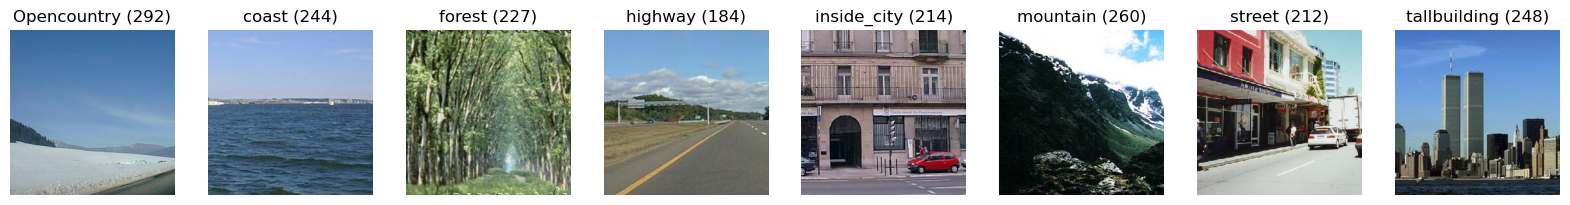

In [5]:
#Let's observe the training dataset
visualize_datasets(train_images_filenames, train_labels, 1)

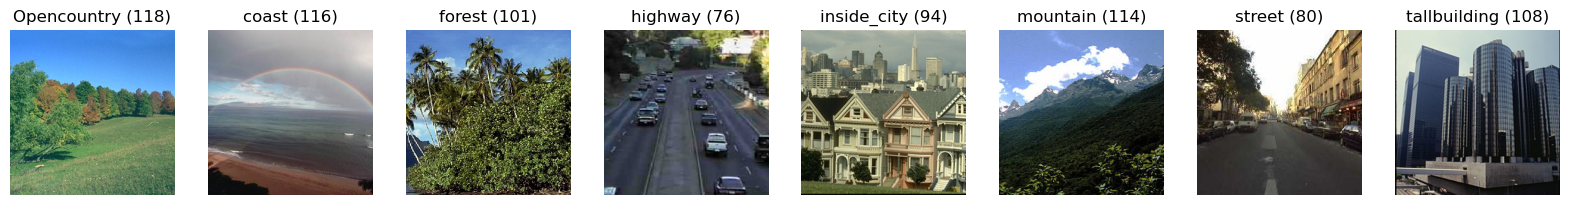

In [6]:
#for the testing dataset
visualize_datasets(test_images_filenames, test_labels, 1)

Let's check the dataset is balanced or not.

<class 'numpy.ndarray'>


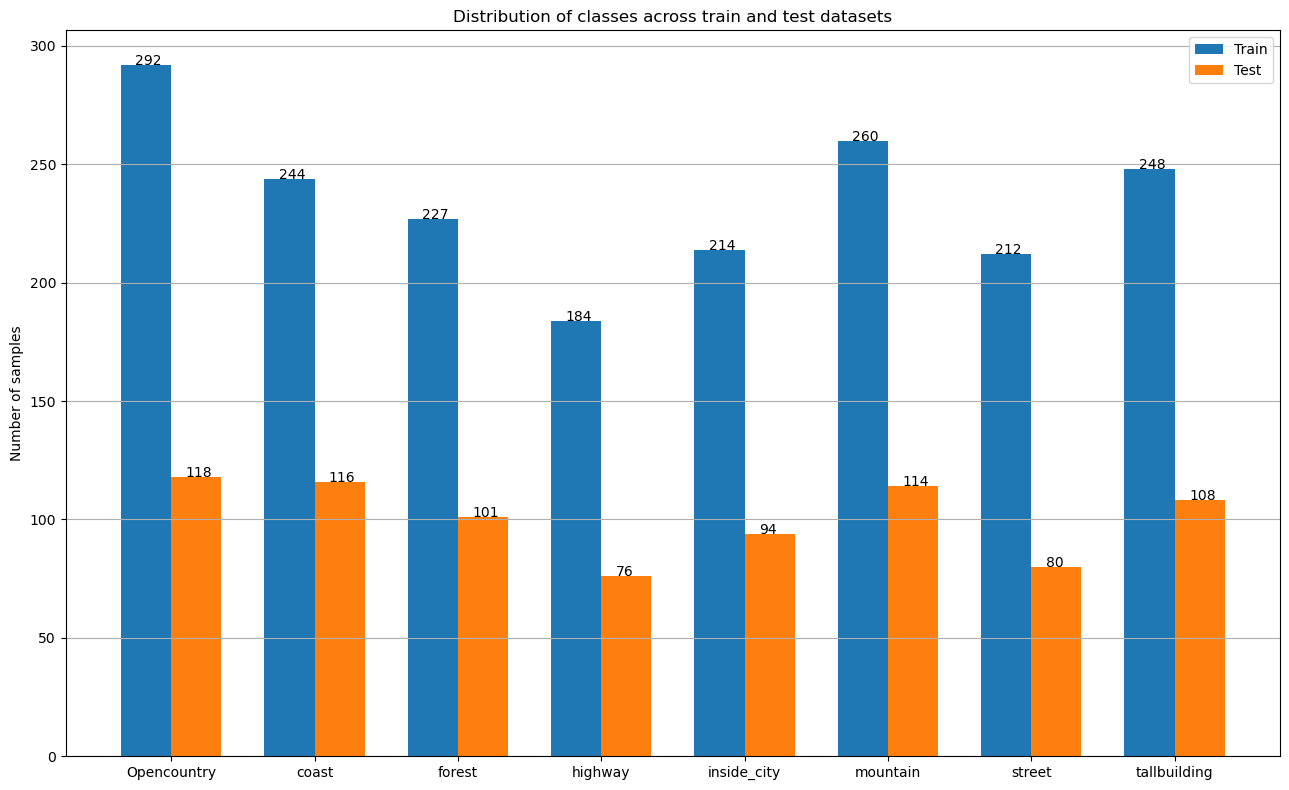

In [7]:
unique_labels = np.unique(train_labels)
train_count = [np.sum(np.array(train_labels) == label) for label in unique_labels]
test_count = [np.sum(np.array(test_labels) == label) for label in unique_labels]

x = np.arange(len(unique_labels))  # the label locations
print(type(x))
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(13, 8))
ax.bar(x - width/2, train_count, width, label='Train')
ax.bar(x + width/2, test_count, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of samples')
ax.set_title('Distribution of classes across train and test datasets')
for i, v in enumerate(train_count):
    plt.text(x[i] - 0.25, v + 0.01, str(v))
for i, v in enumerate(test_count):
    plt.text(x[i]+0.1, v + 0.01, str(v))
ax.set_xticks(x)
ax.set_xticklabels(unique_labels)
ax.legend()
ax.grid(axis='y')

fig.tight_layout()

plt.show()

>   So, our dataset has eight distinct classes with 1881 training images and 807 testing images. Each of the class have on an average of 235 training images and 100 testing images respectively and it almost balanced.

### **3. Continuation of the previous week** <a id="cpw"></a>
In the previous week, we have concluded that, ``DenseSIFT`` is the best descriptor with ``step_size = 10``. We obtained this result, with ``GridSearchCV``. However, we didn't conclude anything on ``scalling`` and we didn't ry ``optuna`` to obtained optimum parameter. We are going to try to perform all the experiments here.

In [8]:
def show_keypoints_dense(img_path, descriptor=None, kps=None):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    if kps is None:
        kps = [descriptor.detect(gray)]
    kp_imgs = []
    for kp in kps:
        kp_imgs.append(cv2.drawKeypoints(img, kp, gray))
    
    fig,axes = plt.subplots(1,len(kps)+1, figsize=(4+len(kps)*2,8))
    
    titles = ['Original_image'] + [f'Keypoints:{len(kp)}' for kp in kps]
    images = [img] + kp_imgs
    for ax, image, title in zip(axes.flatten(), images, titles):
        ax.imshow(image)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [9]:
# To create dense keypoints
def create_dense_kp(img_shape, step_size):
    return [cv2.KeyPoint(x, y, step_size) for y in range(0, img_shape[0], step_size) 
                                          for x in range(0, img_shape[1], step_size)]

# Let's take a random sample image
sample = train_images_filenames[75]

# creating the descriptor
sift = cv2.xfeatures2d.SIFT_create()

# Dense SIFT 
img=cv2.imread(sample)
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

dense_kp = create_dense_kp(gray.shape, step_size=10)                        
_,dense_sift_des = sift.compute(gray, dense_kp)

[ WARN:0@2.418] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_506zufg7xt/croots/recipe/opencv-suite_1664548331847/work/opencv_contrib-4.6.0/modules/xfeatures2d/misc/python/shadow_sift.hpp (15) SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


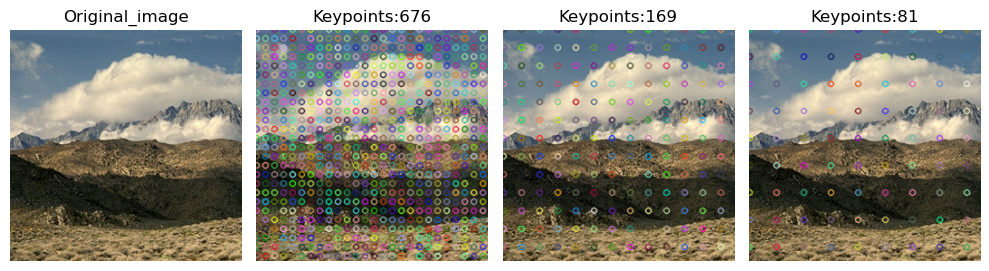

In [10]:
# Show dense keypoints with different steps size
list_steps = [10,20,30]
dense_kps = []
for steps in list_steps:
    dense_kps.append(create_dense_kp(gray.shape, step_size=steps))
show_keypoints_dense(sample, kps=dense_kps)

#### **Tuning the DenseSIFT parameters**
Here, we are trying to visualize the effect of different scale through gridsearchcv with ``codebook_size = 64``, ``LDA components = 7``, and ``svm with RBF kernel`` by 10 fold cross validation as these provides the best performance in the last week.

In [11]:
def plot_metrics(pd_data, param):
    """
    Utility function to plot accuracy, precision, recall, and f1-score
    """
    fig, axes = plt.subplots(1,4, figsize=(20,8), sharex=True)
    titles = ['Cross-val accuracy', 'Cross-val precision', 'Cross-val recall', 'Cross-val f1']
    ylabels = ['Accuracy', 'Precision', 'Recall', 'F1-score']

    ymax = pd_data[titles].max().max()
    ymin = pd_data[titles].min().min()
    
    max_index = pd_data.groupby(param)['Cross-val f1'].idxmax() # get the max f1 of every posible value of the param  
    # get the rows with the max values using the index
    max_rows = pd_data.loc[max_index]


    for ax, title, ylabel in zip(axes.flatten(), titles, ylabels):
        ax.grid(True)
        ax.scatter(max_rows[param], max_rows[title])
        ax.set(xlabel=param, ylabel=ylabel, ylim=(ymin*0.99, ymax*1.01))
        ax.set_title(title)
    
    plt.tight_layout()
    plt.show()

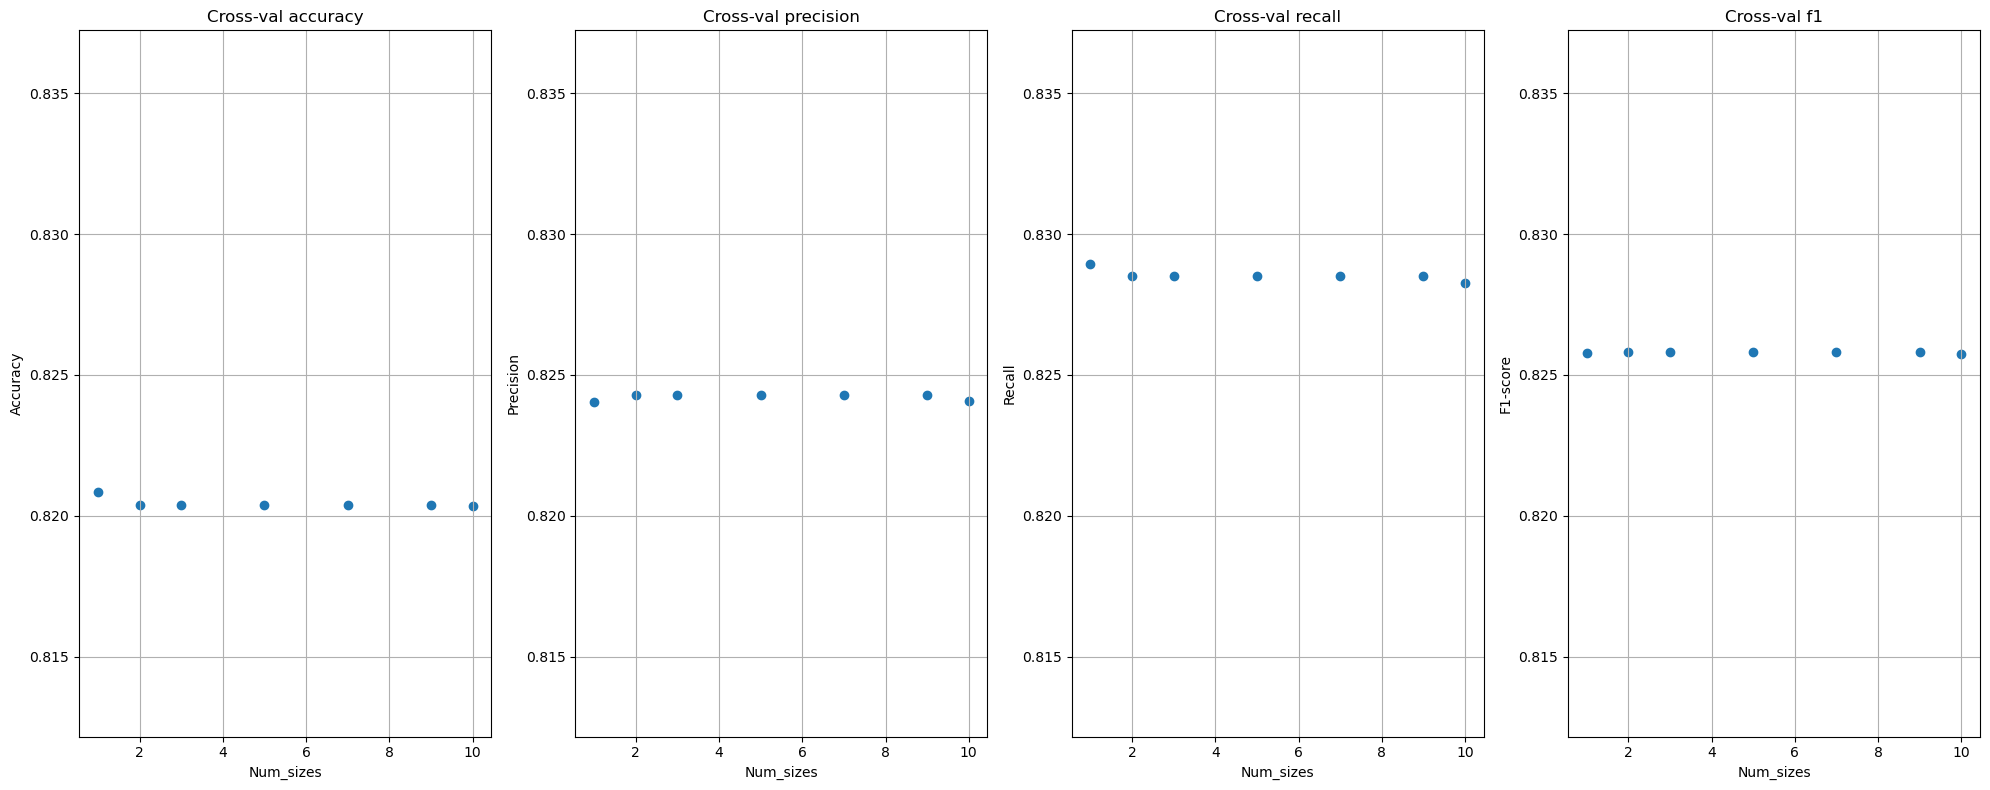

In [12]:
opt_num_size = pd.read_csv('./week2/opt_num_size.csv', index_col = False)
plot_metrics(opt_num_size, 'Num_sizes')

### **Conclusion of this experiments:**
From the above experiment, it can be concluded that the number of sizes (i.e. different scalling) doesn't effect too much on the classification accuracy. So from now onwards we will use ``num_size = 1`` and ``step_size = 10`` as always.

### **4. Normalization** <a id="norm"></a>

In order to improve the data integrity, it's better to normalize our data to avoid different scales of the feature vector. Here, we are going to normalize our histograms of visual words using ``L1``, ``L2``,``Power`` norm and ``StandardScalar`` method. Based on their performance we choose the best one for the further use.

In [13]:
# Normalize the features
def normalize_features(feature, norm='l2'):
    if norm == 'l2':
        return normalize(feature, norm='l2')

    elif norm == 'l1':
        return normalize(feature, norm='l1')

    elif norm == 'power':
        return feature/np.sum([feature],axis=-1).reshape(feature.shape[0],-1)
    
    elif norm == 'scaler':
        return StandardScaler().fit_transform(feature)


#### **Comparative Study**
In order check the effect of normalization we applied gridsearch cv with 10 fold (stratified) cross validation with ``svm`` classifier ``(Kernel = 'rbf')``.

In [14]:
opt_norm_gs = pd.read_csv('./week2/opt_norm_gs.csv', index_col=False)
opt_norm_gs.head()

Normalization  Accuracy   Precision  Recall   F1 Score
0               L1       0.82       0.82     0.82      0.82
1               L2       0.82       0.83     0.82      0.82
2            Power       0.81       0.81     0.81      0.81
3  Standard Scaler       0.80       0.81     0.81      0.81

#### **Conclusions**
Here, all the normalization methods performs very similar, however, ``L1``and ``L2``performs the best. Among them, we choose ``L2``for the rest of our experiments not only because its precision is slightly higher than ``L1``but also ``L2`` tends to minimising the large outliers as this will highlight them more due to the squaring. This is useful when we have colinear or codependent features.

_So, for the rest of the experiments we will go with ``DenseSIFT with step_size = 10, num_size = 1``, and ``L2`` normalization._

### **5. Spatial Pyramid** <a id="spl"></a>

In order to, efficiently aggregates local features into a single global vector however it completely ignore the spatial layout information. We can solve this by computing the keypoints and the descriptors at different pyramidal levels. Spatial pyramidswork by partioning the image into increasingly fine sub-regions and computing histograms of the codewords inside each sub-region.

#### **5.1 Square Sub Region**
As we seen in the first week, this approach divide each region in 4 square sub-regions for each level:
*   **level 0:** we compute the descriptors of the whole image.
*   **level 1:** we divide the image in 4 blocks and compute the descriptors for each of them, and finally concatenate with the whole image descriptor.
*   **level 2:** divde the images into 16 blocks.....
..... and so on...

In [15]:
SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures = 1500)
_, sift_descriptor = SIFTdetector.detectAndCompute(gray, None)

def spatial_pyramid_square(img, descriptor, level=1, step_size=10, num_sizes=1, plot=False):

    # create dense keypoints and compute descriptors
    dense_kp = create_dense_kp(img.shape, step_size=step_size)
    _,des = descriptor.compute(img, dense_kp)

    # for visualization purposes
    if plot:
        fig = plt.figure(figsize=(15,5))
        gs = fig.add_gridspec(4*level, 4+4*level)
        ax = fig.add_subplot(gs[:, :4])
        ax.imshow(img)
        ax.axis('off')

    # list that contains the descriptors of img at different levels,
    # being pyramid_descriptors[0] the descriptors of the whole image
    pyramid_descriptors = [des]

    # pyramid_descriptors[1:4] -> descriptors of the four cells (of size 1/4 of the image size)
    # ...

    for l in range(1,level+1):
        level_factor = 2*l
        cell_h = int(gray.shape[0]/level_factor)
        cell_w = int(gray.shape[1]/level_factor)
        
        dense_kp_cell = create_dense_kp([cell_h,cell_w], step_size=step_size)
            
        for f_h in range(level_factor):
            shift_h = f_h*cell_h
            for f_w in range(level_factor):
                shift_w = f_w*cell_w
                cell = img[shift_h:shift_h+cell_h, shift_w:shift_w+cell_w]
                _,des = descriptor.compute(cell, dense_kp_cell)
                pyramid_descriptors.append(des)

                # for visualization purposes
                if plot:
                    init_row = f_h*4//l
                    last_row = init_row + 4//l
                    init_col = f_w*4//(2*l) + 4*l
                    last_col = init_col + 4//(2*l)
                    ax = fig.add_subplot(gs[init_row:last_row, init_col:last_col])
                    ax.imshow(img[shift_h:shift_h+cell_h, shift_w:shift_w+cell_w])
                    ax.axis('off')


    return pyramid_descriptors

**But how this sub-regions looks like??**

-> _Let's visualize..._

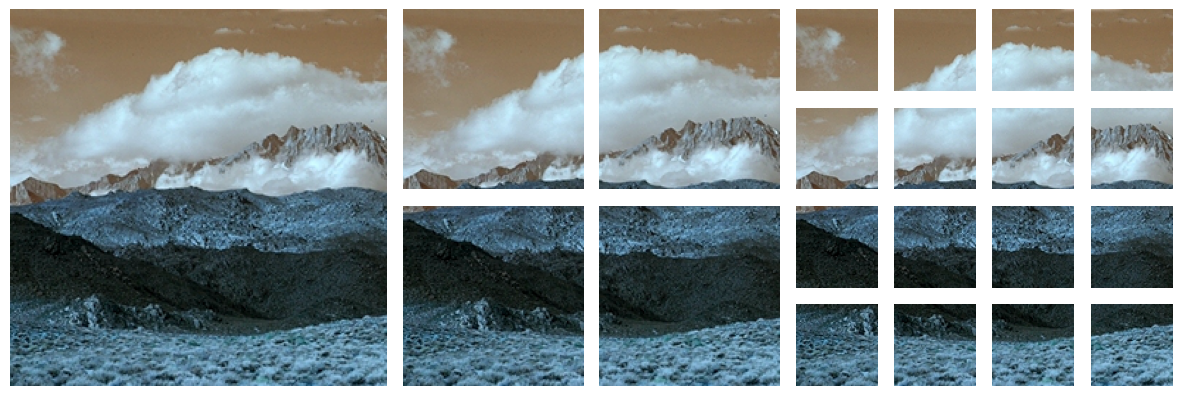

In [16]:
img_blocks = spatial_pyramid_square(img, SIFTdetector, level=2, plot=True)

#### **5.2 Horizontal Sub Region** <a id = 'hsr'></a>
As our provided dataset contained a large number of landscapes images, it can be useful to divide the image into horizontal sub-regions as it has less computational cost than the squared one. So, here we are going to use 4 horizontal rectangle for each level:

In [17]:
def spatial_pyramid_horizontal(img, descriptor, level=1, step_size=10, num_sizes=1, plot=False):

    # create dense keypoints and compute descriptors
    dense_kp = create_dense_kp(img.shape, step_size=step_size)
    _,des = descriptor.compute(img, dense_kp)

    # list that contains the descriptors of img at different levels,
    # being pyramid_descriptors[0] the descriptors of the whole image
    pyramid_descriptors = [des]

    # for visualization purposes
    if plot:
        fig = plt.figure(figsize=(15,5))
        gs = fig.add_gridspec(4*level, 4+4*level)
        ax = fig.add_subplot(gs[:, :4])
        ax.imshow(img)
        ax.axis('off')
        
    # pyramid_descriptors[1:4] -> descriptors of the four cells (of size 1/4 of the image size)
    # ...
    for l in range(1,level+1):
        level_factor = 4*l
        cell_h = int(gray.shape[0]/level_factor)
        
        dense_kp_cell = create_dense_kp([cell_h,gray.shape[1]], step_size=step_size)
            
        for f_h in range(level_factor):
            shift_h = f_h*cell_h
            cell = img[shift_h:shift_h+cell_h,:]

            _,des = descriptor.compute(cell, dense_kp_cell)

            pyramid_descriptors.append(des)

            # for visualization purposes
            if plot:
                init_row = f_h*(4*level)//(4*l)
                last_row = init_row + (4*level)//(4*l)
                ax = fig.add_subplot(gs[init_row:last_row, 4*l:4*l+4])
                ax.imshow(img[shift_h:shift_h+cell_h,:])
                ax.axis('off')

    return pyramid_descriptors

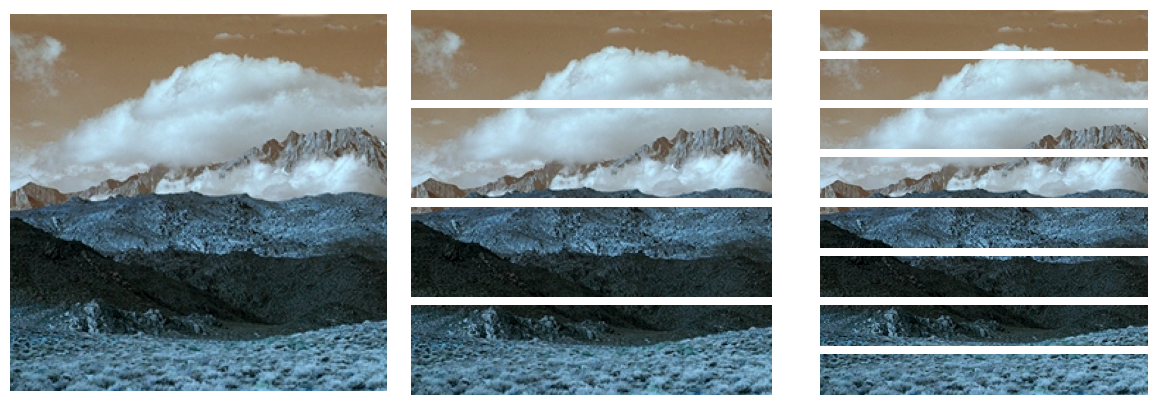

In [18]:
#Let's visualize
img_blocks = spatial_pyramid_horizontal(img, SIFTdetector, level=2, plot=True)

#### **Tuning the Spatial Pyramid Level for Horizontal Sub Regions**
In horizontal sub regions we also need to find, what is the optimum number of cells, in which we are going to divide the image. For example, in the above setup we divide each sub region into 4 cells. This is a important parameter to tune as its effect the classification performance and it is a primary cause of overfitting.

Here, we perform the experiment at ``level = 1``, as we know from the previous week, its provide faster and efficient output.

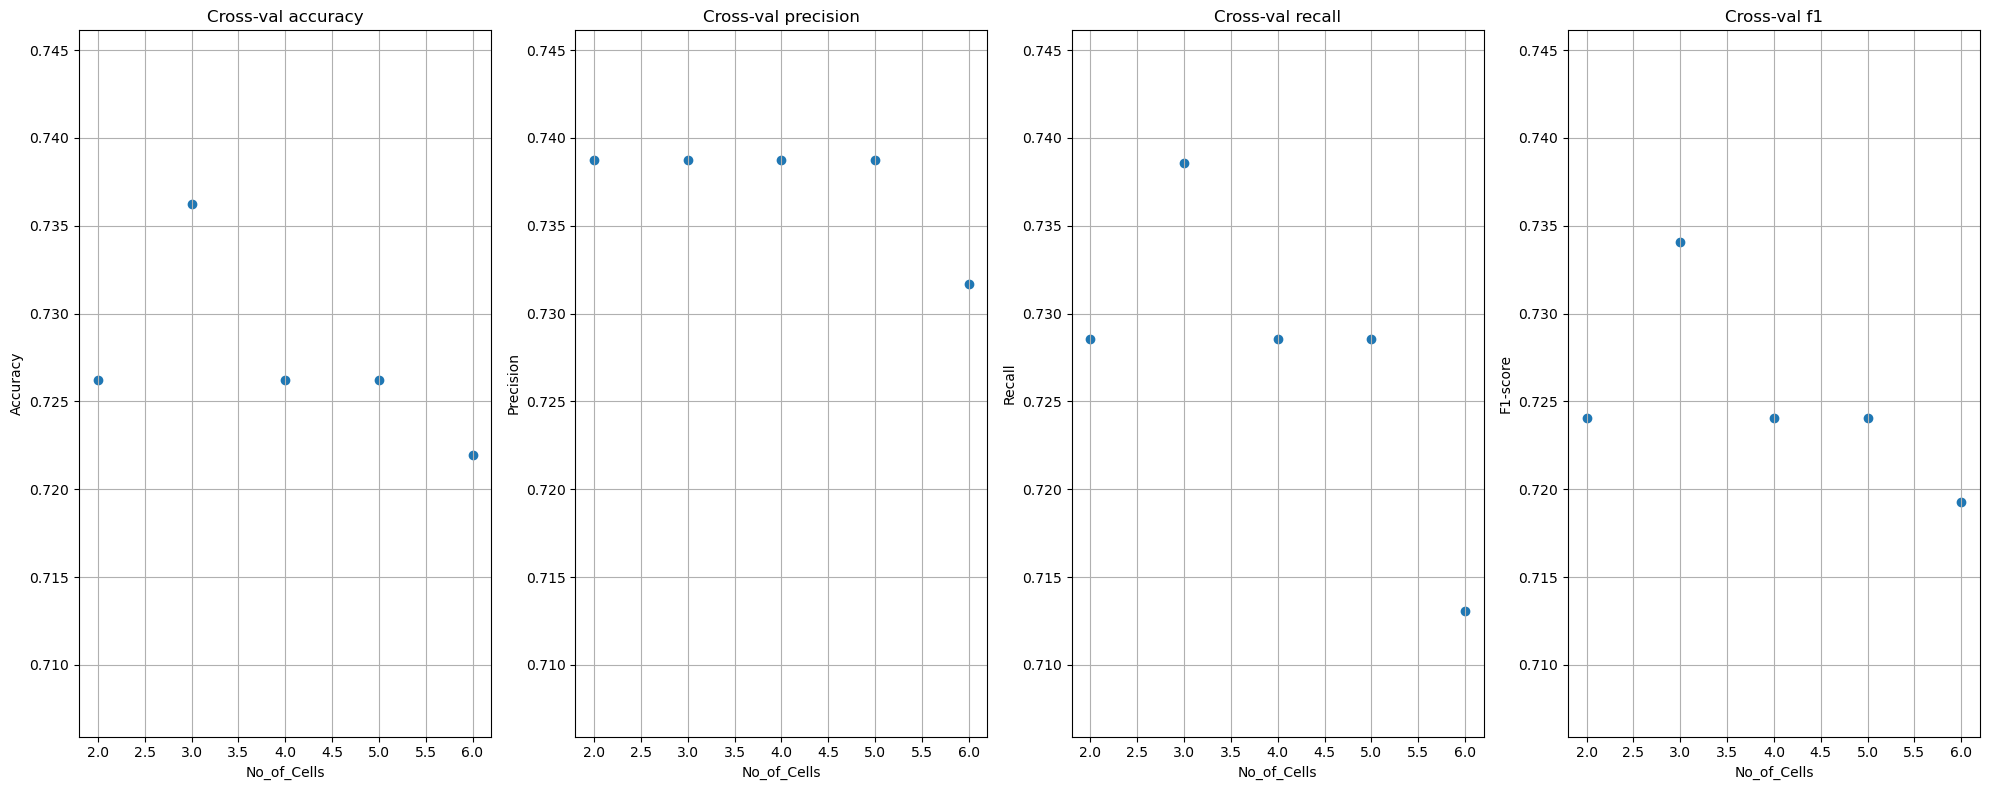

In [19]:
opt_num_cell_gs = pd.read_csv('./week2/num_of_cells.csv', index_col= False)
plot_metrics(opt_num_cell_gs, 'No_of_Cells')

It can be observed that, with the increasing no. of cells(i.e. at 6) the model start overfitting. So, for horizontal sub-regions we will proceed with ``no. of cells = 3``.

#### **Square vs Horizontal**
_A battle of optimum pyramid level_

Now we know the optimum no. of cells for horizontal sub regions. Let's find out the optimum no. of levels for horizontal sub-regions anf if it outperforms the squared one.

In [20]:
#groupby for the comprsion
opt_pyramid_level = pd.read_csv('./week2/optimize_pyrmaid_shape.csv', index_col = False)
df = pd.DataFrame(opt_pyramid_level)
gr = df[['Subregion shape', 'Spatial pyramid level', 'Cross-val accuracy', 'Cross-val precision', 'Cross-val recall', 'Cross-val f1']]
gr_shape = gr.groupby(['Subregion shape', 'Spatial pyramid level']).mean()
gr_shape.reset_index()
#com_shape = gr_shape[['Cross-val accuracy', 'Cross-val precision', 'Cross-val recall', 'Cross-val f1']]
#com_shape
#X = list(gr_shape.iloc[:,0])
#print(X)

/var/folders/d_/0g_w8mls3jb45q24svvm3g_h0000gn/T/ipykernel_1354/810200438.py:2: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  opt_pyramid_level = pd.read_csv('./week2/optimize_pyrmaid_shape.csv', index_col = False)


Subregion shape  Spatial pyramid level  Cross-val accuracy  \
0      horizontal                      0            0.726228   
1      horizontal                      1            0.721969   
2      horizontal                      2            0.731011   
3          square                      0            0.726228   
4          square                      1            0.730461   
5          square                      2            0.732059   

   Cross-val precision  Cross-val recall  Cross-val f1  
0             0.738736          0.728570      0.724052  
1             0.731661          0.723050      0.719261  
2             0.742993          0.732380      0.728558  
3             0.738736          0.728570      0.724052  
4             0.746213          0.730864      0.728850  
5             0.746035          0.733385      0.730335

In [21]:
#accumulating all the values to compare
acc = list(gr_shape.iloc[:,0])
pre = list(gr_shape.iloc[:,1])
rec = list(gr_shape.iloc[:,2])
f1 = list(gr_shape.iloc[:,3])

#horizontal
hor_acc = acc[0:3]
hor_pre = pre[0:3]
hor_rec = rec[0:3]
hor_f1 = f1[0:3]

#square
sq_acc = acc[3:6]
sq_pre = pre[3:6]
sq_rec = rec[3:6]
sq_f1 = f1[3:6]



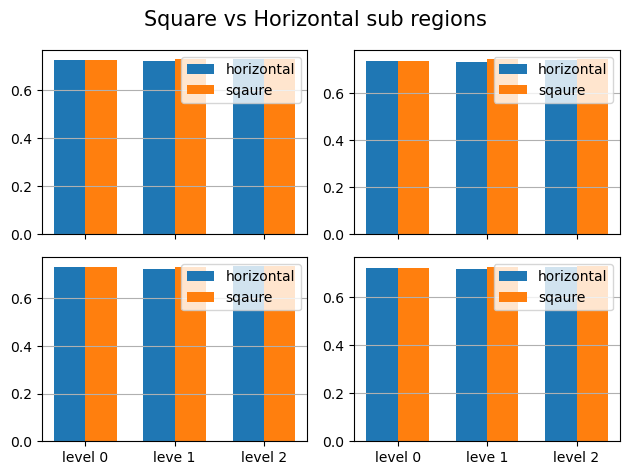

In [22]:
#creating subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True)

x = np.arange(3)
#add title
fig.suptitle('Square vs Horizontal sub regions', fontsize = 15)
width = 0.35  # the width of the bars

ax1.bar(x - width/2, hor_acc, width, label='horizontal')
ax1.bar(x + width/2, sq_acc, width, label='sqaure')
ax1.legend()
ax1.grid(axis='y')
ax2.bar(x - width/2, hor_pre, width, label='horizontal')
ax2.bar(x + width/2, sq_pre, width, label='sqaure')
ax2.legend()
ax2.grid(axis='y')
ax3.bar(x - width/2, hor_rec, width, label='horizontal')
ax3.bar(x + width/2, sq_rec, width, label='sqaure')
ax3.legend()
ax3.grid(axis='y')
ax4.bar(x - width/2, hor_f1, width, label='horizontal')
ax4.bar(x + width/2, sq_f1, width, label='sqaure')
ax4.legend()
ax4.grid(axis='y')
#change the xsticks to levels
plt.xticks([0, 1, 2],['level 0','leve 1', 'level 2'])


fig.tight_layout()

plt.show()

#### **Conclusions**
*   The performance of the horizontal and squared sub region is very similar but sqaured sub region outperform the horizontal one by a slight margin.

*   Although the the performance at level 2 and level 1 is very similar (sometimes level 2 is higher than1), level 2 has a huge computational time than level 1. So we have decided to go with level 1 for the further experiments.

***So, from now onwards we'll use Dense SIFT with step size = 10, pyramid level =1 with square sub region by L2 normalization.***

In [23]:
#Here, we are going to compute the training descriptors for our model with
#DensSIFT step size = 10, spatial pyramid level = 1, sub-regions = square
Train_descriptors = []
Train_label_per_descriptor = []

train_pyramid_descriptors = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima = cv2.imread(filename)
    gray = cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    pyramid_des = spatial_pyramid_horizontal(gray, SIFTdetector, level=1, step_size=10, num_sizes=1, plot=False)
    train_pyramid_descriptors.append(pyramid_des)
    Train_descriptors.append(pyramid_des[0])
    Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)

### **6. Clustering** <a id="kmeans"></a>
This section is as same as the previous week. We use MiniBatchKMeans with ``codebook_size = 64``.

In [24]:
#Let's try the minibatch Kmeans
k = 64
codebook_by_KMeans = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook_by_KMeans.fit(D)

MiniBatchKMeans(batch_size=1280, compute_labels=False, n_clusters=64,
                random_state=42, reassignment_ratio=0.0001, verbose=False)

For each train image, we project each keypoint descriptor to its closest visual word that represent each of the images with the frequency of each visual word through histograms.

#### **Bag of visual words for training dataset**

In [25]:
# Compute the pyramid histograms of the descriptors of the image
def spatial_pyramid_histograms(pyramid_descriptor, codebook, k):
    visual_words=np.zeros(k*len(pyramid_descriptor),dtype=np.float32)
    for d in range(len(pyramid_descriptor)):
        # If no keypoints were detected, the frequency of the visual words is 0
        if pyramid_descriptor[d] is None:
            visual_words[d*k:d*k+k]=np.zeros(k)
        else:
            words=codebook.predict(pyramid_descriptor[d])
            visual_words[d*k:d*k+k]=np.bincount(words,minlength=k)
    return visual_words

In [26]:
visual_words_pyramid=np.zeros((len(train_pyramid_descriptors),k*len(train_pyramid_descriptors[0])),dtype=np.float32)
for i in range(len(train_pyramid_descriptors)):
    visual_words_pyramid[i,:] = spatial_pyramid_histograms(train_pyramid_descriptors[i], codebook_by_KMeans, k)

# As aforementioned, it is a good practice to normalize the data
vw_normalized = normalize_features(visual_words_pyramid,'l2')

#### **Bag of visual words for testing dataset**

In [27]:
Test_descriptors = []
visual_words_test=np.zeros((len(test_images_filenames),visual_words_pyramid.shape[1]),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    pyramid_des = spatial_pyramid_horizontal(gray, SIFTdetector, level=1, step_size=10, num_sizes=1, plot=False)
    Test_descriptors.append(pyramid_des[0])
    visual_words_test[i,:] = spatial_pyramid_histograms(pyramid_des, codebook_by_KMeans, k)

vw_test_normalized = normalize_features(visual_words_test,'l2')

### **7. Linear Discriminant Analysis** <a id="lda"></a>
For LDA, we need the no. of components to be ``<= min(num_classes-1, nfeatures)``. LDA helps to obtain a decision boundary around each cluster of a class. It then projects the data points to new dimensions in a way that the clusters are separable from each other. So, we have ``n - (classes -1)`` distances to optimize.

In [28]:
lda = LinearDiscriminantAnalysis(n_components=7)
VWlda_train = lda.fit_transform(vw_normalized,train_labels)
VWlda_test = lda.transform(vw_test_normalized)

Now Let us visualize the effect of the LDA for maximum separability through ``t-SNE``.

In [29]:
# run t-SNE
from sklearn.manifold import TSNE
# perplexity parameter can be changed based on the input datatset
# dataset with larger number of variables requires larger perplexity
# set this value between 5 and 50 (sklearn documentation)
# verbose=1 displays run time messages
# set n_iter sufficiently high to resolve the well stabilized cluster
# get embeddings
tsne_em = TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=1).fit_transform(vw_normalized)

/opt/anaconda3/envs/m3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/m3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1881 samples in 0.000s...
[t-SNE] Computed neighbors for 1881 samples in 0.092s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1881
[t-SNE] Computed conditional probabilities for sample 1881 / 1881
[t-SNE] Mean sigma: 0.261123
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.937202
[t-SNE] KL divergence after 1000 iterations: 1.437490


In [30]:
# plot t-SNE clusters
from bioinfokit.visuz import cluster
cluster.tsneplot(score=tsne_em)

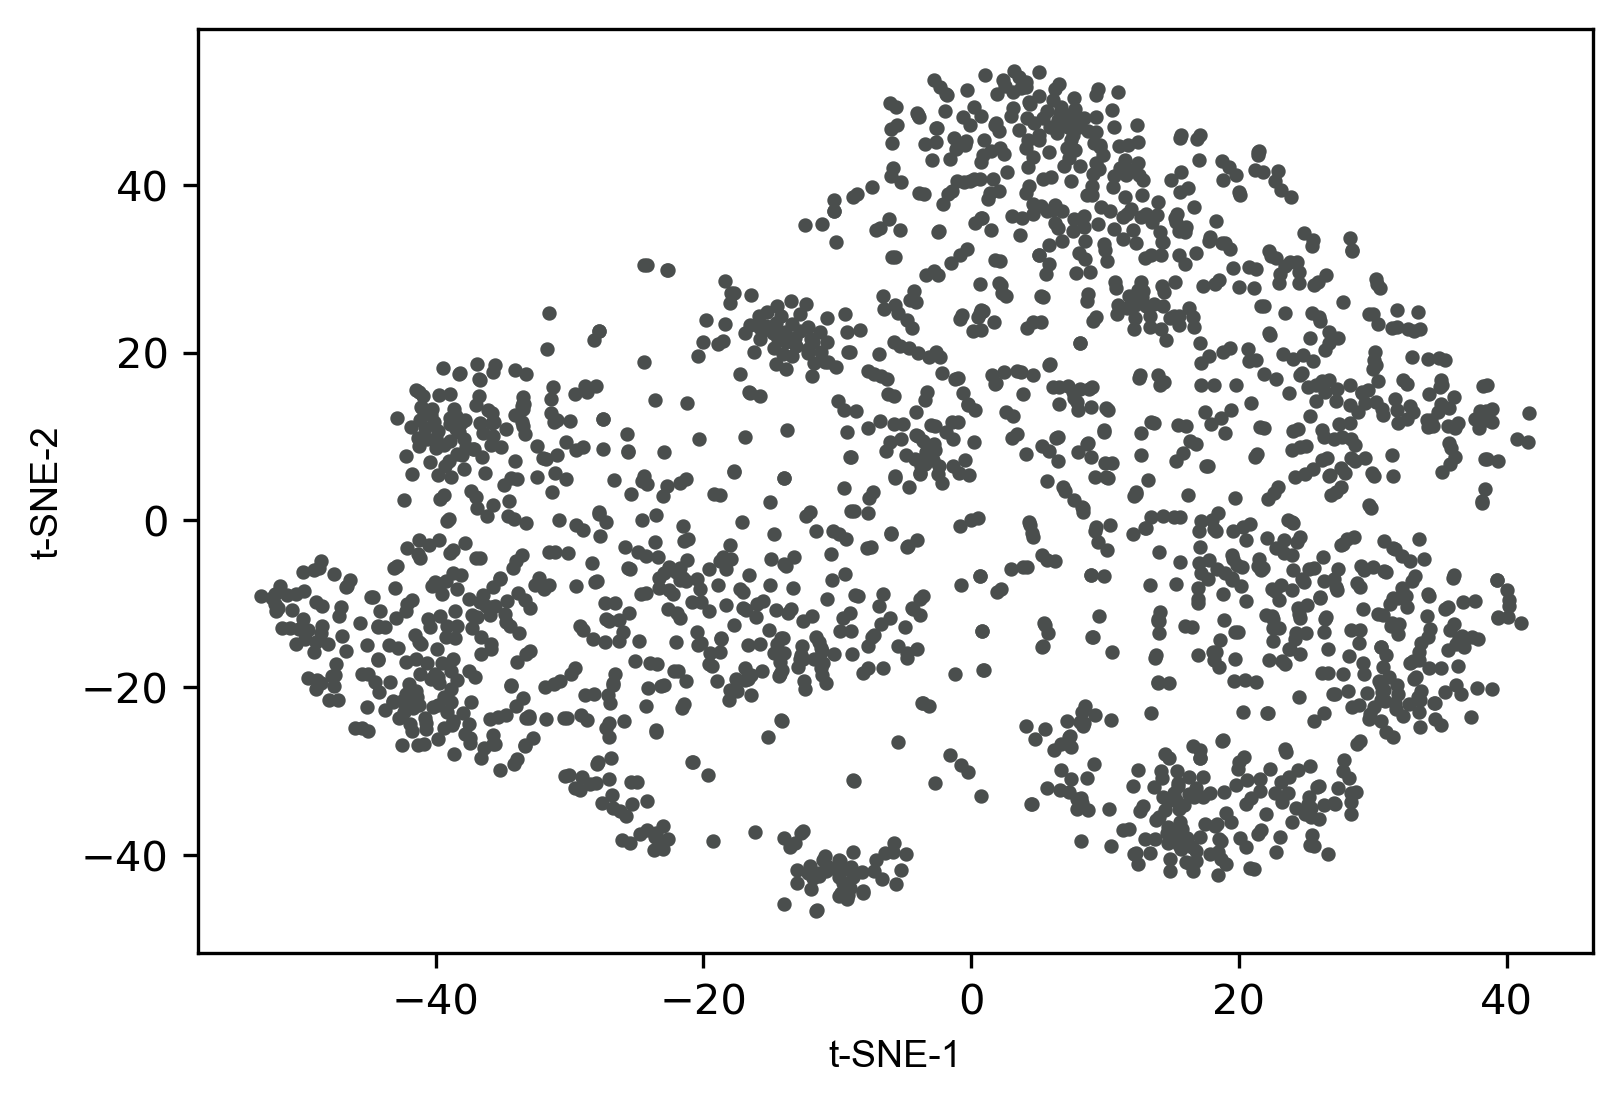

In [31]:
from IPython.display import Image
Image('tsne_2d.png')

This is the visualization before LDA. Let's see how much we can improve with the LDA.

In [32]:
tsne_em_lda = TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=1).fit_transform(VWlda_train)


/opt/anaconda3/envs/m3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/m3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1881 samples in 0.004s...
[t-SNE] Computed neighbors for 1881 samples in 0.047s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1881
[t-SNE] Computed conditional probabilities for sample 1881 / 1881
[t-SNE] Mean sigma: 1.016348
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.622742
[t-SNE] KL divergence after 1000 iterations: 1.031062


In [33]:
cluster.tsneplot(score=tsne_em_lda)

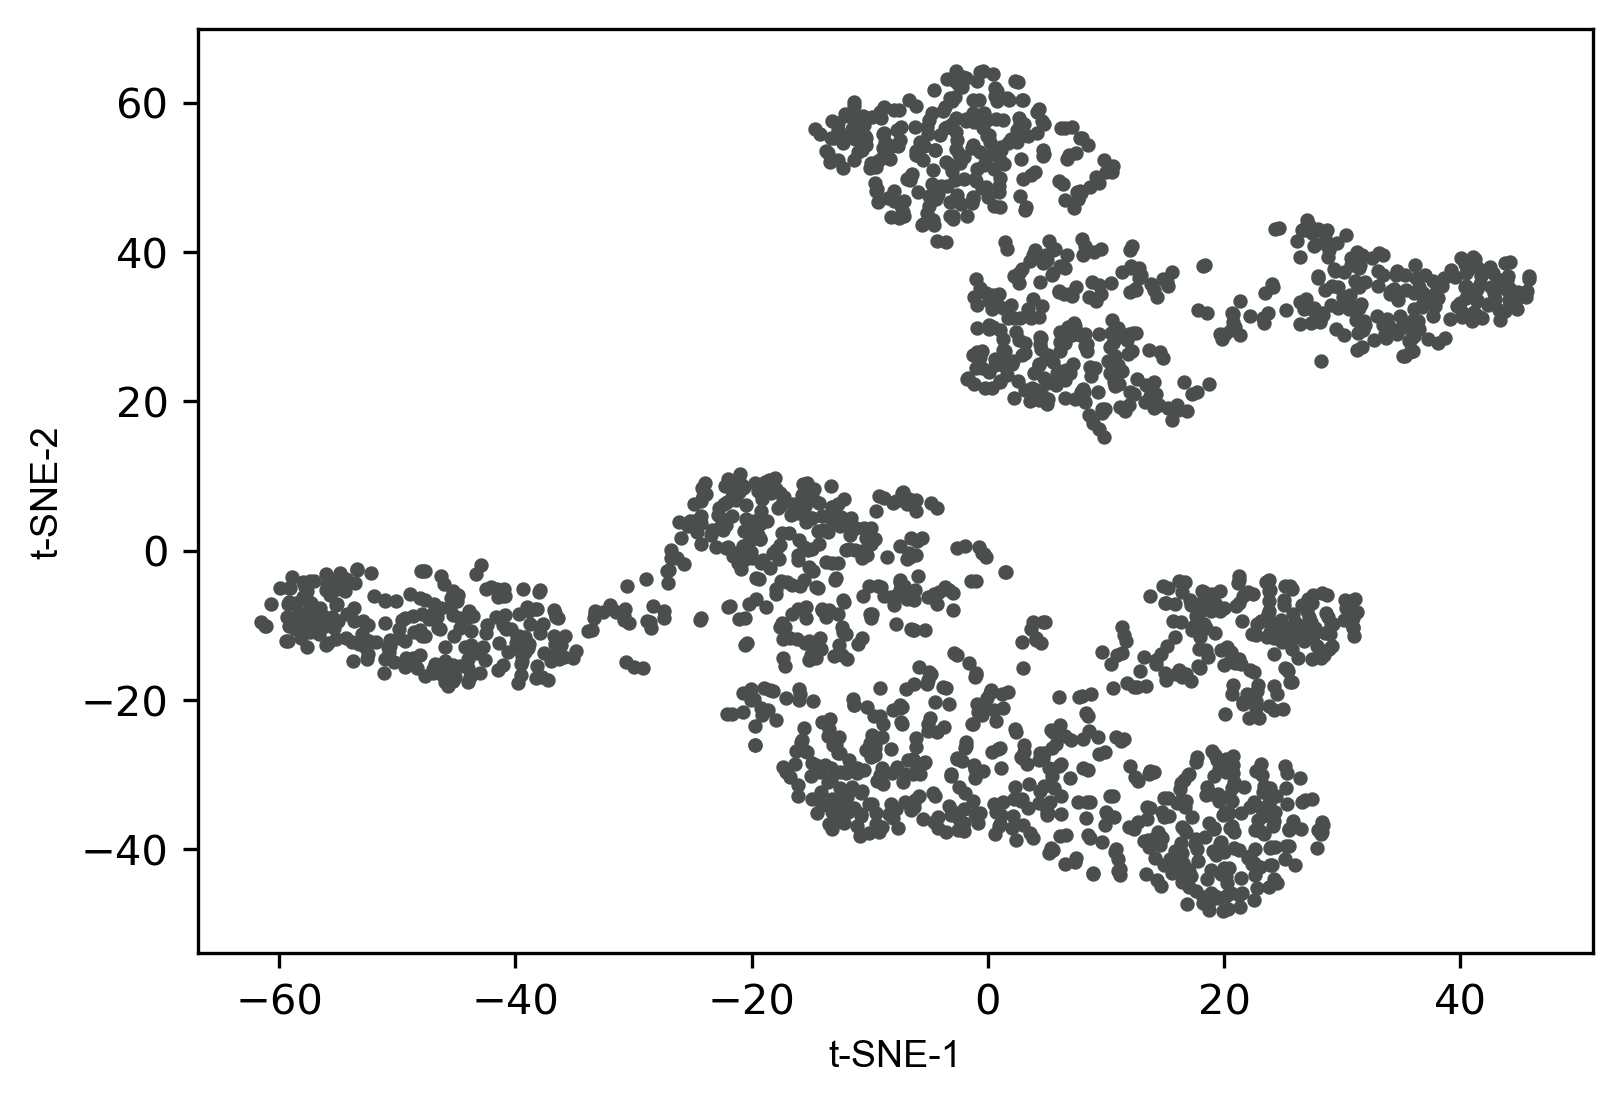

In [34]:
from IPython.display import Image
Image('tsne_2d.png')

It can be observed that, LDA attains maximum separability. So from now onwards, we will use LDA with ``N_components = 7`` for getting better performance.

### **8. Classifiers** <a id="cls"></a>
Based on the above training features we are going to defined the following classifers to classify the given dataset.

#### **8.1 SVM Classifier**<a id = "svm"></a>
We build an SVM classifier and train it with the train descriptors.

In addition to the kernels used by the sklearn function: ``linear``, ``poly``, ``rbf``, and ``sigmoid``, we create our own kernel: the ``histogram intersection kernel``, which is useful for comparisons between histograms. For this reason, it makes sense to use it in this specific problem. It is defined as:

\begin{equation*}
    K_{int} (A,B) = \sum_{i=1}^{m} min (a_i, b_i)
\end{equation*}

To decide which is the kernel that works better in our case, we compute the accuracy (mean and standard deviation) with 10 (stratified) fold cross-validation.

In [35]:
# you need to define a callable function to pass the histogram intersection kernel to svm.SVC
def histogramIntersection(data_1, data_2):
    kernel = np.zeros((data_1.shape[0], data_2.shape[0]))

    for d in range(data_1.shape[1]):
        column_1 = data_1[:, d].reshape(-1, 1)
        column_2 = data_2[:, d].reshape(-1, 1)
        kernel += np.minimum(column_1, column_2.T)

    return kernel

In [36]:
#Let's find out which kernel gives use the best performance
parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid',histogramIntersection)}
svc = svm.SVC() 
grid = GridSearchCV(svc, parameters, cv=10)
grid.fit(VWlda_train, train_labels)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'kernel': ('linear', 'poly', 'rbf', 'sigmoid',
                                    <function histogramIntersection at 0x7fa3eb3db4c0>)})

In [37]:
svm_kernel_pd = pd.DataFrame.from_dict(grid.cv_results_)
svm_kernel_pd[['param_kernel','mean_test_score','std_test_score','rank_test_score']]

param_kernel  mean_test_score  \
0                                             linear         0.909079   
1                                               poly         0.887293   
2                                                rbf         0.911207   
3                                            sigmoid         0.913329   
4  <function histogramIntersection at 0x7fa3eb3db...         0.903766   

   std_test_score  rank_test_score  
0        0.031802                3  
1        0.032947                5  
2        0.029549                2  
3        0.033078                1  
4        0.029682                4

In [38]:
#Now let's optimize the other parameter of the svm and find the best one.
param_grid = { 'C':[0.1,1,100,1000],'degree':[1,2,3,4,5,6],'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
model = svm.SVC() 
grid = GridSearchCV(model, param_grid=param_grid)
grid.fit(VWlda_train, train_labels)

print(grid.best_score_)
print(grid.best_estimator_)

0.9144026186579378
SVC(C=100, degree=1, gamma=0.0001)


#### **Conclusions**
*   Regarding the ``poly`` kernel, we can observe that we're obtaining worse results. In our dataset, images of different classes share visual words (e.g. trees in both forests and open country classes), theirfore, choosing of best degree of polynomial very difficult. And, it is doesn't make sense to use linear kernel too.

*   In this case, it is recommended to use the ``sigmoid`` kernel, which creates non-linear combinations of the features to uplift the samples onto a higher-dimensional feature space where a linear decision boundary can be used. And indeed, we obtain the best accuracy with this kernel.

*   We can certify that the histogram interesection kernel that we implemented can be used for SVM, as we get good results using it. This is because this kernel is useful in our specific problem, as we're using histograms as features. However, it stills performs worse than sigmoid and RBF kernels. For this reason, we'll use ``sigmoid`` kernel.

*   The training accuracy is 91.5% which is similar to the last week performance.

#### **8.2 Light Gradient Boosting Machine**
*   Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm.

*   It can handle a variety of data types, relationships, distributions, which makes it more robust than the rest of the ensemble classifier.

*   But it also has a diversity of hyperparameter which need to be fine-tune. But for this time we are going to use ``Optuna`` instead of ``GridsearchCV``.


In [39]:
import lightgbm as lgb
import numpy as np
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split

import optuna

# You can use Matplotlib instead of Plotly for visualization by simply replacing `optuna.visualization` with
# `optuna.visualization.matplotlib` in the following examples.
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

SEED = 42

np.random.seed(SEED)

/opt/anaconda3/envs/m3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### **Define the objective function.**

In [40]:
#For optuna, we need convert our classes into numeric list. Let's do that.
l_train = []
for i in train_labels:
    if(i == 'Opencountry'):
        l_train.append(0)
    elif(i == 'coast'):
        l_train.append(1)
    elif(i == 'forest'):
        l_train.append(2)
    elif(i == 'highway'):
        l_train.append(3)
    elif(i == 'inside_city'):
        l_train.append(4)
    elif(i == 'street'):
        l_train.append(5)
    elif(i == 'mountain'):
        l_train.append(6)
    elif(i == 'tallbuilding'):
        l_train.append(7)

l_test = []
for j in test_labels:
    if(j == 'Opencountry'):
        l_test.append(0)
    elif(j == 'coast'):
        l_test.append(1)
    elif(j == 'forest'):
        l_test.append(2)
    elif(j == 'highway'):
        l_test.append(3)
    elif(j == 'inside_city'):
        l_test.append(4)
    elif(j == 'street'):
        l_test.append(5)
    elif(j == 'mountain'):
        l_test.append(6)
    elif(j == 'tallbuilding'):
        l_test.append(7)

In [41]:
def objective(trial):
    data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
    #train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)
    dtrain = lgb.Dataset(VWlda_train, label=l_train)
    dvalid = lgb.Dataset(VWlda_test, label=l_test)

    param = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "auc")
    gbm = lgb.train(
        param, dtrain, valid_sets=[dvalid], verbose_eval=False, callbacks=[pruning_callback]
    )

    preds = gbm.predict(VWlda_test)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(l_test, pred_labels)
    return accuracy

In [42]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
)
study.optimize(objective, n_trials=100, timeout=600)

[I 2023-01-16 02:11:15,724] A new study created in memory with name: no-name-49221f30-bf2c-4ee9-85cf-dc1d7adfcd69
/opt/anaconda3/envs/m3/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-01-16 02:11:15,798] Trial 0 finished with value: 0.22304832713754646 and parameters: {'bagging_fraction': 0.6247240713084175, 'bagging_freq': 7, 'min_child_samples': 75}. Best is trial 0 with value: 0.22304832713754646.
/opt/anaconda3/envs/m3/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and

#### **Visualize the optimization history. ``See plot_optimization_history()`` for the details.**

/var/folders/d_/0g_w8mls3jb45q24svvm3g_h0000gn/T/ipykernel_1354/1455980257.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<AxesSubplot: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

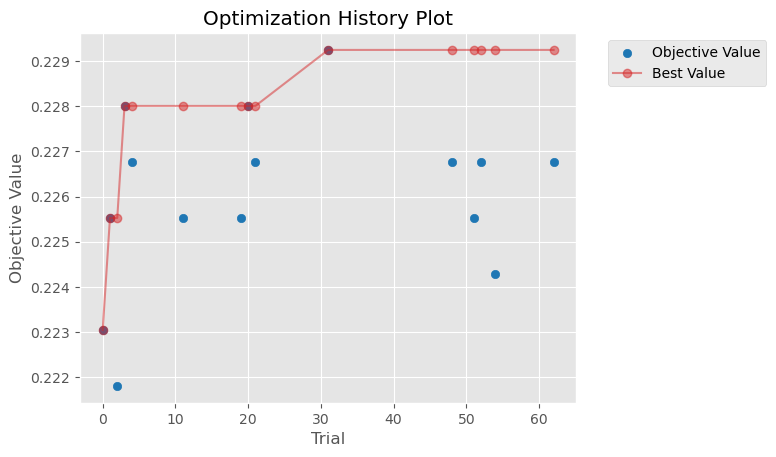

In [43]:
optuna.visualization.matplotlib.plot_optimization_history(study)

#### **Visualize the learning curves of the trials. See ``plot_intermediate_values()`` for the details.**

/var/folders/d_/0g_w8mls3jb45q24svvm3g_h0000gn/T/ipykernel_1354/2140463885.py:1: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_intermediate_values(study)


<AxesSubplot: title={'center': 'Intermediate Values Plot'}, xlabel='Step', ylabel='Intermediate Value'>

/opt/anaconda3/envs/m3/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)
/opt/anaconda3/envs/m3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


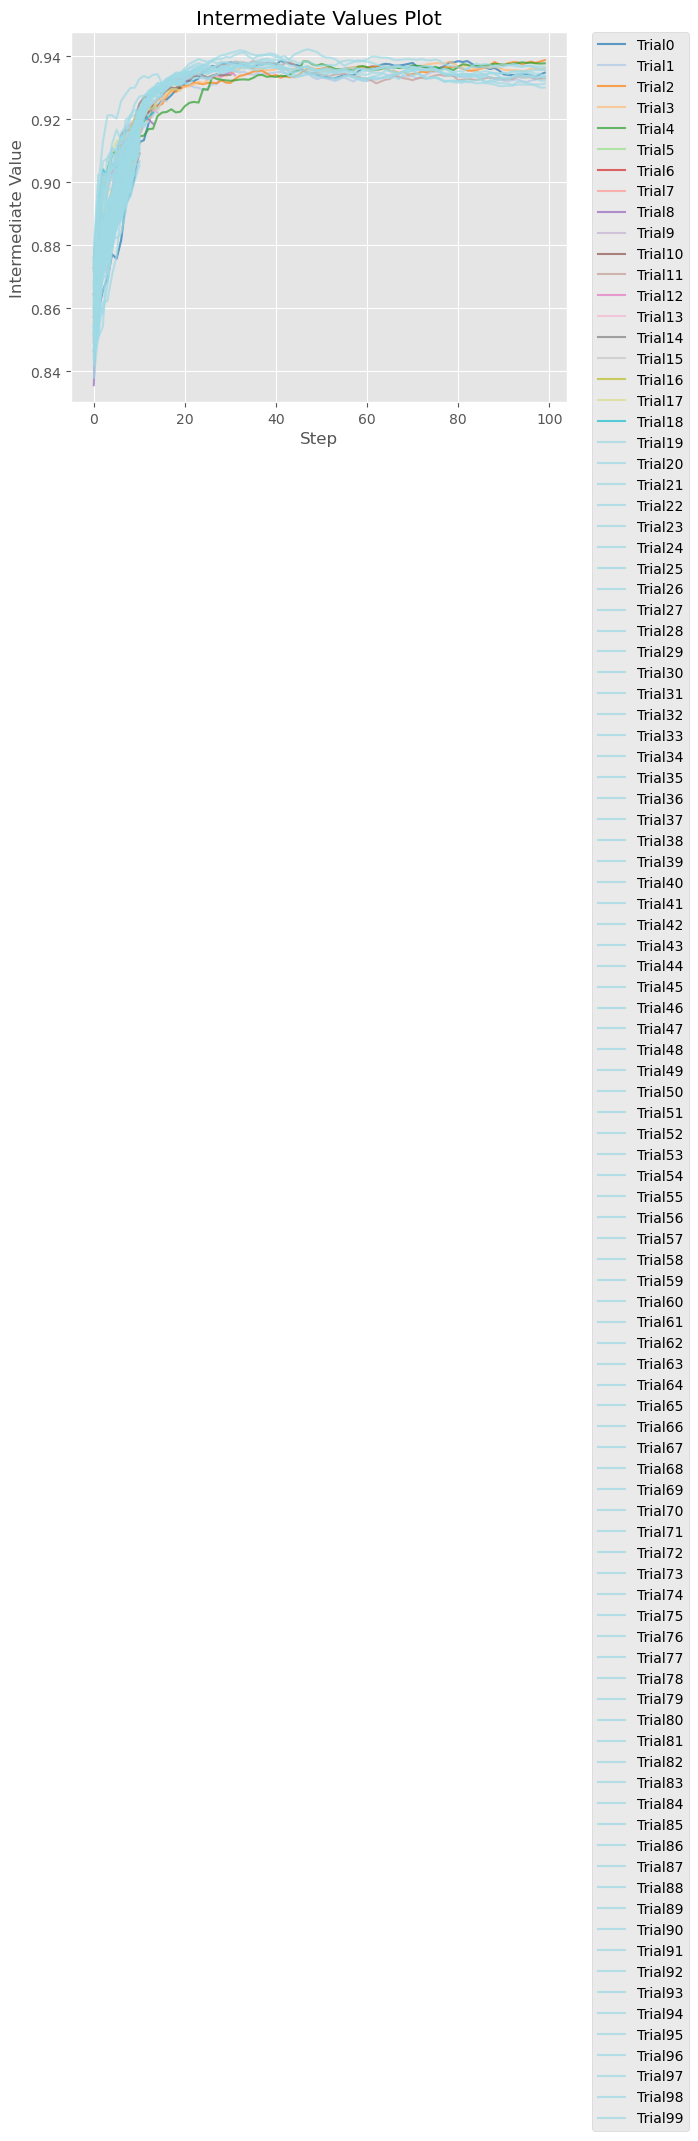

In [44]:
optuna.visualization.matplotlib.plot_intermediate_values(study)

#### **Visualize high-dimensional parameter relationships. See ``plot_parallel_coordinate()`` for the details.**

/var/folders/d_/0g_w8mls3jb45q24svvm3g_h0000gn/T/ipykernel_1354/437109074.py:1: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study)


<AxesSubplot: title={'center': 'Parallel Coordinate Plot'}>

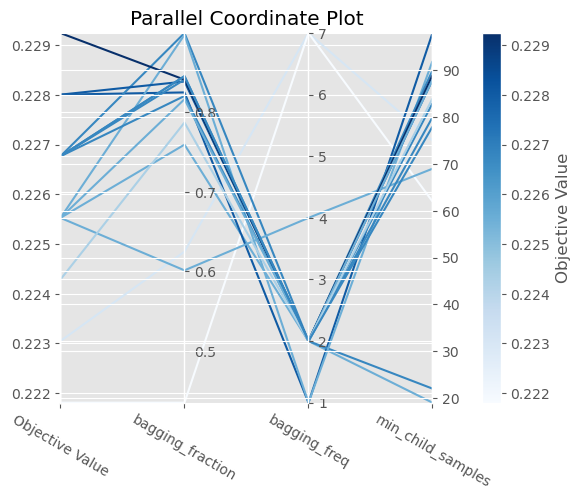

In [45]:
optuna.visualization.matplotlib.plot_parallel_coordinate(study)

#### **Visualize hyperparameter relationships. See ``plot_contour()`` for the details.**

/var/folders/d_/0g_w8mls3jb45q24svvm3g_h0000gn/T/ipykernel_1354/2367328650.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study)
[W 2023-01-16 02:11:19,414] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


array([[<AxesSubplot: ylabel='bagging_fraction'>, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: ylabel='bagging_freq'>, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: xlabel='bagging_fraction', ylabel='min_child_samples'>,
        <AxesSubplot: xlabel='bagging_freq'>,
        <AxesSubplot: xlabel='min_child_samples'>]], dtype=object)

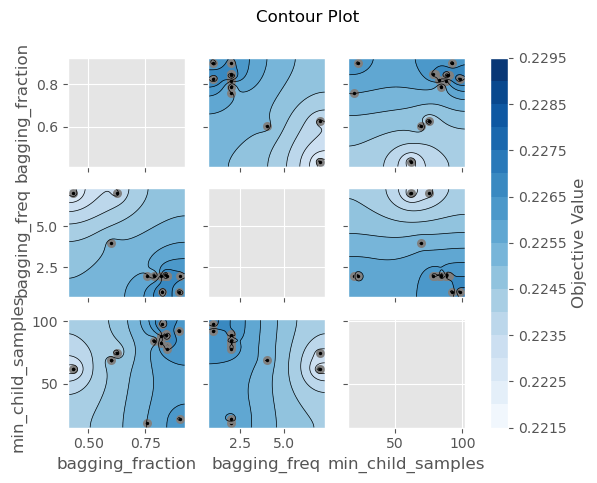

In [46]:
optuna.visualization.matplotlib.plot_contour(study)

#### **Visualize parameter importances. See ``plot_param_importances()`` for the details.**

/var/folders/d_/0g_w8mls3jb45q24svvm3g_h0000gn/T/ipykernel_1354/1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<AxesSubplot: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

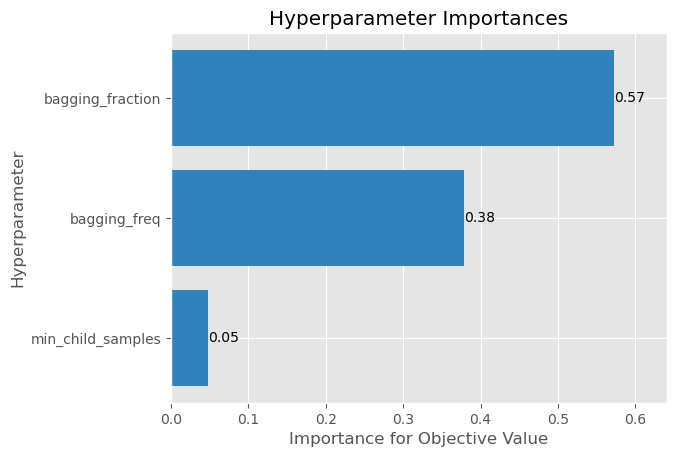

In [47]:
optuna.visualization.matplotlib.plot_param_importances(study)

Learn which hyperparameters are affecting the trial duration with hyperparameter importance.

/var/folders/d_/0g_w8mls3jb45q24svvm3g_h0000gn/T/ipykernel_1354/2983977879.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(


<AxesSubplot: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for duration', ylabel='Hyperparameter'>

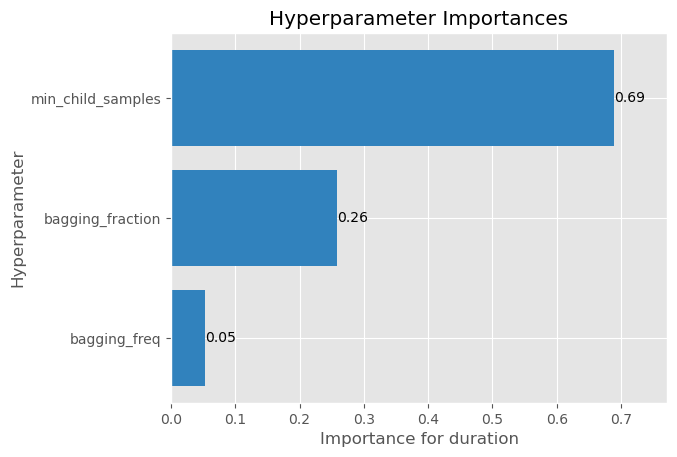

In [48]:
optuna.visualization.matplotlib.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

#### **Visualize empirical distribution function. See ``plot_edf()`` for the details.**

/var/folders/d_/0g_w8mls3jb45q24svvm3g_h0000gn/T/ipykernel_1354/3191722373.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf(study)


<AxesSubplot: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

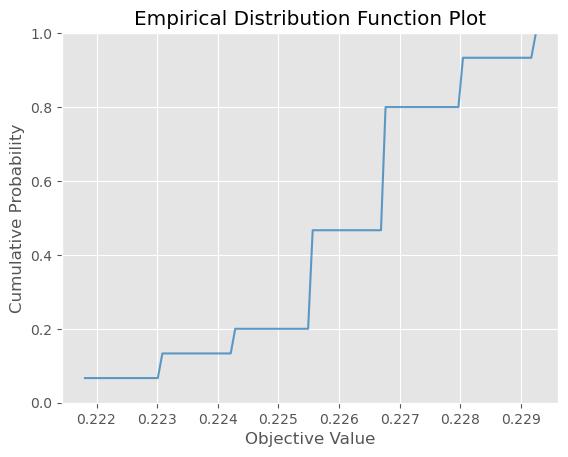

In [49]:
optuna.visualization.matplotlib.plot_edf(study)

#### **Conclusions on Light GBM**
*   From the learning curves we came to know that, it converges in only 18 iterations so, it is very fast to implement.

*   From the Hyperparameter importance we came to know that, ``bagging fraction`` is the most importance parameter and take more duration to optimize.

*   From the parallel coordinate plot, it can be concluded that, ``bagging faction`` and ``bagging_freq`` is highly dependent on each other.

*   We get ``bagging fraction = 0.84``, ``bagging_freq = 2``, and ``min_child_samples = 89``, so let's test it.


#### **Train the LightGBM**

In [50]:
#training with lightGBM
params = {}
params['learning_rate'] = 0.03
params['boosting_type'] = 'gbdt'
params['objective'] = 'multiclass'
params['metric'] = 'multi_logloss'
params['max_depth'] = 8
params['num_class'] = 8
params['bagging_fraction'] = 0.84
params['bagging_freq'] = 2
params['min_child_samples'] = 89

#training and testing data
dtrain = lgb.Dataset(VWlda_train, label=l_train)
dvalid = lgb.Dataset(VWlda_test, label=l_test)

#training the model
clf = lgb.train(params, dtrain, 18)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1881, number of used features: 7
[LightGBM] [Info] Start training from score -1.862805
[LightGBM] [Info] Start training from score -2.042391
[LightGBM] [Info] Start training from score -2.114609
[LightGBM] [Info] Start training from score -2.324623
[LightGBM] [Info] Start training from score -2.173583
[LightGBM] [Info] Start training from score -2.182973
[LightGBM] [Info] Start training from score -1.978877
[LightGBM] [Info] Start training from score -2.026130
[LightGBM] [Warnin

### **Testing with LightGBM**

In [51]:
#prediction on the test dataset
y_pred = clf.predict(VWlda_test)

#argmax()
y_pred_l = [np.argmax(line) for line in y_pred]

#using precision score for error metrics
precision_score(y_pred_l, l_test, average = None).mean()

0.765924389099086

### **Conclusions**
With Light GBM the test accuracy is only 76% which is far below from support vector machine. This is beacuse Light GBM is sensitive to overfiiting because it split the tree leaf-wise and produces much complex trees. So for rest of the experiments we will go with support vector machine.

### **9. Fisher Vector** <a id = "fv"></a>
The main concept behind using this method is to use a soft encoding and soft assignment at the same time.
Utilizing Gaussian mixture models (GMM) for the vocabulary encoding and fisher vectors for image representation.

Covariance type: We use a diagonal covariance matrix in this method limiting the possible forms of the Gaussian distributions, but at the same time, greatly increases computation speed without sacrificing generality.

***Normalization:***

_L2_

$  x_j = \frac{x_j}{\sum \limits _{q=1} ^{2dK} x_q}$

_Square-rooting_

$  x_j = sign(x_j) |x_j|^{0.5}$


#### **Normalization**

In [52]:
def normalize_fisher(fisher_vectors,norm='l2'):
    fisher_vectors_stk = np.vstack(fisher_vectors)
    if norm == 'l2':
        return fisher_vectors_stk / np.linalg.norm(fisher_vectors_stk)
    elif norm == 'square-rooting':
        return np.sign(fisher_vectors_stk) * np.abs(fisher_vectors_stk) ** 0.5

In [53]:
fisher_gs = pd.read_csv('./week2/optimize_sift_fisher.csv', index_col = False)
fisher_gs = fisher_gs[fisher_gs['PCA perc']==1]
max_index = fisher_gs.groupby('Norm fisher')['Cross-val f1'].idxmax()
fisher_gs.loc[max_index,['Norm fisher', 'Cross-val accuracy', 'Cross-val precision', 'Cross-val recall', 'Cross-val f1']]

/var/folders/d_/0g_w8mls3jb45q24svvm3g_h0000gn/T/ipykernel_1354/3287750781.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  fisher_gs = pd.read_csv('./week2/optimize_sift_fisher.csv', index_col = False)


Norm fisher  Cross-val accuracy  Cross-val precision  Cross-val recall  \
4               l2            0.659759             0.715464          0.665564   
38  square-rooting            0.759173             0.777815          0.763299   

    Cross-val f1  
4       0.665096  
38      0.758714

So for fisher vector the ``sqaure rooting`` is the best option to normalize.

#### **Defining the Fisher Vector**
The basic idea behind the Fisher Kernel method is to train a generative model on data to derive a Fisher Kernel for a discriminative support vector machine. The fisher kernel gives a natural similarity measure that takes into account the underlying probability distribution in the low level feature space.

In [54]:
def fisher_vector(xx, gmm):
    """Computes the Fisher vector on a set of descriptors.
    Parameters
    ----------
    xx: array_like, shape (N, D) or (D, )
        The set of descriptors
    gmm: instance of sklearn mixture.GMM object
        Gauassian mixture model of the descriptors.
    Returns
    -------
    fv: array_like, shape (K + 2 * D * K, )
        Fisher vector (derivatives with respect to the mixing weights, means
        and variances) of the given descriptors.
    Reference
    ---------
    J. Krapac, J. Verbeek, F. Jurie.  Modeling Spatial Layout with Fisher
    Vectors for Image Categorization.  In ICCV, 2011.
    http://hal.inria.fr/docs/00/61/94/03/PDF/final.r1.pdf
    """
    xx = np.atleast_2d(xx)
    N = xx.shape[0]

    # Compute posterior probabilities.
    Q = gmm.predict_proba(xx)  # NxK

    # Compute the sufficient statistics of descriptors.
    Q_sum = np.sum(Q, 0)[:, np.newaxis] / N
    Q_xx = np.dot(Q.T, xx) / N
    Q_xx_2 = np.dot(Q.T, xx ** 2) / N

    # Compute derivatives with respect to mixing weights, means and variances.
    d_pi = Q_sum.squeeze() - gmm.weights_
    d_mu = Q_xx - Q_sum * gmm.means_
    d_sigma = (
        - Q_xx_2
        - Q_sum * gmm.means_ ** 2
        + Q_sum * gmm.covariances_
        + 2 * Q_xx * gmm.means_)

    # Merge derivatives into a vector.
    return np.hstack((d_pi, d_mu.flatten(), d_sigma.flatten()))

#### **Clustering**
Here we are going to use ``Gaussian Mixture Model`` with a small codebook size 16. This provide a lot more contextual information than the ``MiniBatchKMeans`` as its provide estimates of the probability that each data point belongs to each cluster.

In [55]:
from sklearn.mixture import GaussianMixture
k = 16
codebook_gm = GaussianMixture(n_components=k, verbose=False, covariance_type='diag', random_state=42)
codebook_gm.fit(D)

GaussianMixture(covariance_type='diag', n_components=16, random_state=42,
                verbose=False)

However, its computational time is much higher than the ``MiniBatchKmeans``.

#### **Generating the Bag of Words with Visual Features**

In [56]:
train_fisher = []
for train_descriptor in train_pyramid_descriptors:
    train_fisher.append(fisher_vector(train_descriptor[0], codebook_gm))

test_fisher = []
for test_descriptor in Test_descriptors:
    test_fisher.append(fisher_vector(test_descriptor[0], codebook_gm))


train_fisher_normalized = normalize_fisher(train_fisher, 'square-rooting')
test_fisher_normalized = normalize_fisher(test_fisher, 'square-rooting')

#### **Normalizing the Features**

In [57]:
VWlda_train_fisher = lda.fit_transform(train_fisher_normalized,train_labels)
VWlda_test_fisher = lda.transform(test_fisher_normalized)

#### **Classifying with SVM**

In [58]:
#Let's find out which kernel gives use the best performance
parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid',histogramIntersection)}
svc = svm.SVC() 
grid = GridSearchCV(svc, parameters, cv=10)
grid.fit(VWlda_train_fisher, train_labels)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'kernel': ('linear', 'poly', 'rbf', 'sigmoid',
                                    <function histogramIntersection at 0x7fa3eb3db4c0>)})

In [59]:
svm_kernel_pd = pd.DataFrame.from_dict(grid.cv_results_)
svm_kernel_pd[['param_kernel','mean_test_score','std_test_score','rank_test_score']]

param_kernel  mean_test_score  \
0                                             linear         0.997872   
1                                               poly         0.978194   
2                                                rbf         0.998404   
3                                            sigmoid         0.998936   
4  <function histogramIntersection at 0x7fa3eb3db...         0.998936   

   std_test_score  rank_test_score  
0        0.002606                4  
1        0.007319                5  
2        0.002438                3  
3        0.002128                1  
4        0.002128                1

The interesting fact is that both ``histogram intersection`` and ``sigmoid`` has highest training accuracy and training accuracy is almost closed to 1, which is a sign of overfitting. So Let's test.

In [60]:
#Now let's optimize the other parameter of the svm and find the best one.
param_grid = { 'C':[0.1,1,100,1000],'degree':[1,2,3,4,5,6],'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
model = svm.SVC() 
grid = GridSearchCV(model, param_grid=param_grid)
grid.fit(VWlda_train_fisher, train_labels)

print(grid.best_score_)
print(grid.best_estimator_)

0.9989361702127659
SVC(C=1, degree=1, gamma=0.1)


### **10. Cross Validation** <a id="cv"></a>

>   **Note that:** we have already used the cross-validation on the gridsearch to obtain the best parameters. However, here we are showing the best performance with the combination of all the experiments that we performed above.

In [61]:
classifier = svm.SVC(kernel="sigmoid", degree=1, C=100, gamma=0.0001)
cv_scores = cross_validate(classifier, VWlda_train, 
                          train_labels,scoring = ['accuracy', 'precision_macro', 'recall_macro','f1_macro'], 
                          cv=10)

In [62]:
cross_validation_pd = pd.DataFrame.from_dict(cv_scores)
cross_validation_pd.round(4)

fit_time  score_time  test_accuracy  test_precision_macro  \
0    0.0183      0.0071         0.9312                0.9380   
1    0.0170      0.0050         0.9096                0.9145   
2    0.0170      0.0050         0.8723                0.8869   
3    0.0172      0.0050         0.9362                0.9407   
4    0.0171      0.0049         0.9149                0.9173   
5    0.0169      0.0050         0.8830                0.8903   
6    0.0172      0.0049         0.9255                0.9251   
7    0.0179      0.0051         0.9681                0.9740   
8    0.0172      0.0052         0.9362                0.9398   
9    0.0169      0.0050         0.8617                0.8688   

   test_recall_macro  test_f1_macro  
0             0.9232         0.9270  
1             0.9063         0.9083  
2             0.8830         0.8824  
3             0.9396         0.9386  
4             0.9191         0.9164  
5             0.8802         0.8840  
6             0.9331         0.9271  
7             0.9705         0.9711  
8             0.9340         0.9362  
9             0.8590         0.8594

In [63]:
print("%0.2f accuracy with a std dev of %0.2f" % (cv_scores['test_accuracy'].mean(), cv_scores['test_accuracy'].std()))
print("%0.2f precision with a std dev of %0.2f" % (cv_scores['test_precision_macro'].mean(), cv_scores['test_precision_macro'].std()))
print("%0.2f recall with a std dev of %0.2f" % (cv_scores['test_recall_macro'].mean(), cv_scores['test_recall_macro'].std()))
print("%0.2f F1-score with a std dev of %0.2f" % (cv_scores['test_f1_macro'].mean(), cv_scores['test_f1_macro'].std()))

0.91 accuracy with a std dev of 0.03
0.92 precision with a std dev of 0.03
0.91 recall with a std dev of 0.03
0.92 F1-score with a std dev of 0.03


**Conclusions**
*   Within the different 10 folds, the system presents a low std dev of 0.03, which allows us to validate the consistency of our system.

*   We obtain an accuracy of 0.92 and an average precision, recall and F1-score of 0.92 and almost 100% training accuracy with fisher vector which maybe a sign of overfitting.

### **11. Test Validation** <a id = "tv"></a>

Here we are going to test first the performance of the support vector machine with and without using fisher vector.

#### **Testing without fisher vector**

In [64]:
classifier = svm.SVC(kernel="sigmoid",C = 100, degree=1, gamma=0.0001)
classifier.fit(VWlda_train, train_labels)

#vwtestlda = lda.transform() 
test_lda_prediction = classifier.predict(VWlda_test)
test_lda_precision, test_lda_recall, test_lda_fscore, _ = precision_recall_fscore_support(test_labels, test_lda_prediction, average='macro')
test_lda_accuracy = classifier.score(VWlda_test, test_labels)

print("%0.2f accuracy" % (test_lda_accuracy))
print("%0.2f precision" % (test_lda_precision))
print("%0.2f recall" % (test_lda_recall))
print("%0.2f F1-score" % (test_lda_fscore))

0.82 accuracy
0.82 precision
0.82 recall
0.82 F1-score


The test accuracy is similar to the previous week. Let's see it can be improved with the fisher vector or not.

#### **Testing with Fisher Vector**

In [65]:
model = svm.SVC(kernel=histogramIntersection,C = 1, degree=1, gamma=0.1)
model.fit(VWlda_train_fisher, train_labels)

#vwtestlda = lda.transform(visual_words_test) 
test_lda_prediction = model.predict(VWlda_test_fisher)
test_lda_precision, test_lda_recall, test_lda_fscore, _ = precision_recall_fscore_support(test_labels, test_lda_prediction, average='macro')
test_lda_accuracy = model.score(VWlda_test_fisher, test_labels)

print("%0.2f accuracy" % (test_lda_accuracy))
print("%0.2f precision" % (test_lda_precision))
print("%0.2f recall" % (test_lda_recall))
print("%0.2f F1-score" % (test_lda_fscore))

0.14 accuracy
0.18 precision
0.13 recall
0.12 F1-score


The model is purely overfit. Maybe with Higher Kernel Size this can be reduced but its too computationally expensive that we can't perform those experiments.

**Conclusions**

As observed, the performance of the classifier (without fisher vector) in the test dataset is acceptable, but much worse than with the training dataset. One of the reasons can be an overfitting of the classifier, which means that it's not generalizing well to unseen datasets. With a larger training dataset or other classifier (may be support vector machine), we expect to improve the results.

### **12. Visualization of Results** <a id = "roc"></a>
Let's start with the confusion matrix and ROC curve.

#### **Confusion Matrix and ROC curve**
Let's start with SVM without fisher vector.

/opt/anaconda3/envs/m3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


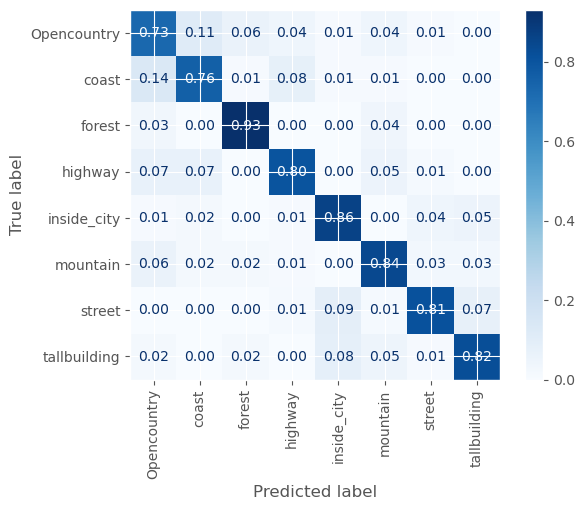

In [66]:
plot_confusion_matrix(classifier, VWlda_test, test_labels, cmap=plt.cm.Blues,normalize='true',xticks_rotation='vertical',values_format='.2f')

What if we include fisher vector??

/opt/anaconda3/envs/m3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


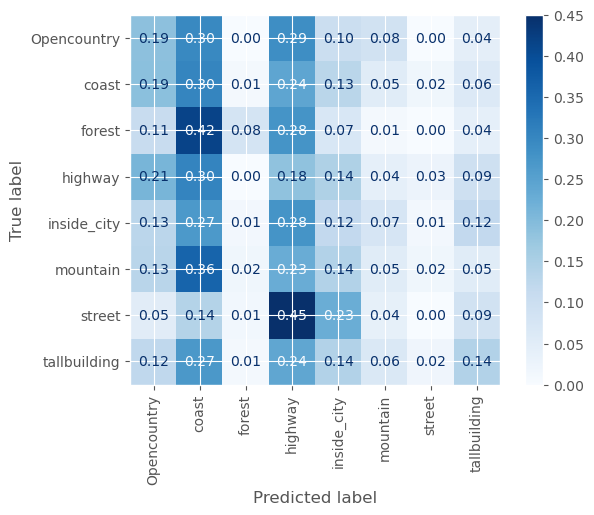

In [67]:
plot_confusion_matrix(model, VWlda_test_fisher, test_labels, cmap=plt.cm.Blues,normalize='true',xticks_rotation='vertical',values_format='.2f')

It will highly missclassified the data with fisher vector.

Additionally, we will plot the ROC curve to visually analyze the behaviour of our classifier when treating it as a one-vs-all binary classifier.

In [68]:
# first we need to binarize the labels
y_train = LabelBinarizer().fit_transform(train_labels)
y_test = LabelBinarizer().fit_transform(test_labels)
n_classes = y_train.shape[1]
print(y_train)

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


In [69]:
# classifier
clf = OneVsRestClassifier(svm.SVC())
clf.fit(VWlda_train, y_train)
y_score = clf.decision_function(VWlda_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [70]:
# Then interpolate all ROC curves 
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

/var/folders/d_/0g_w8mls3jb45q24svvm3g_h0000gn/T/ipykernel_1354/1169533911.py:4: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


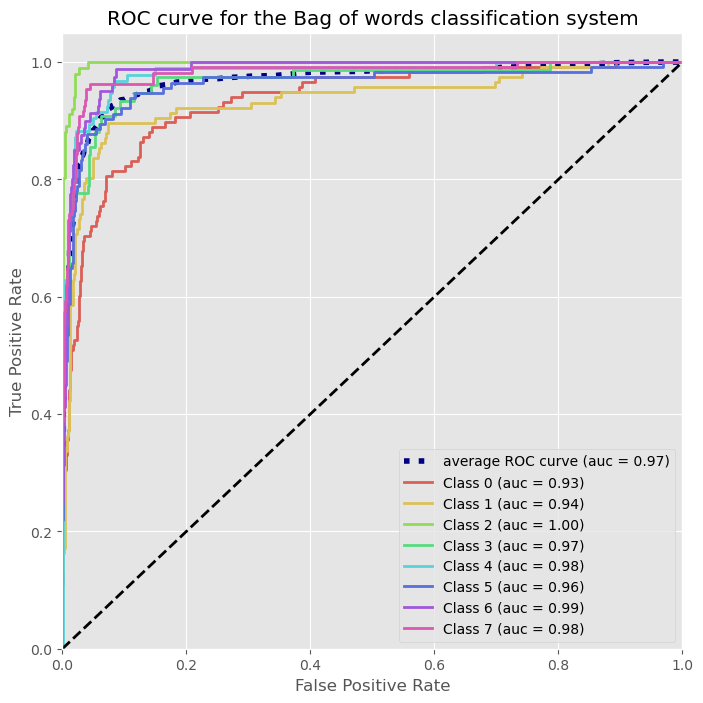

In [71]:
# Plot all ROC curves
plt.figure(figsize=(8,8))
lw = 2
plt.plot(fpr["macro"], tpr["macro"],
         label='average ROC curve (auc = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

palette = sns.color_palette("hls", 8)
colors = cycle(palette)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Class {0} (auc = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the Bag of words classification system')
plt.legend(loc="lower right")
plt.show()

**Conclusions**

*   With the confusion matrix we can validate that most of the predictions are correct, as the percentage of correct predictions for each class is quite high.

*   We can observe (both in the confusion matrix and in the ROC curves) that the class that is best classified is ***class 2 (i.e. Forest)***. We can see how the forest dataset is mainly formed by trees, that have a similar pattern of textures and colors, doesn't matter how the forest is.

*   On the other hand, the class that is worst classified is class 0, which is Opencountry. The Opencountry dataset shows different kinds of landscapes, from desert to mountains, in some cases with a big part of the image being the blue sky and others showing just a bit of clouds, so it can be easily misclassified. This blue sky also explains the high number of misclassifications between the Opencountry and Coast classes, as it's mistaken with the sea.

#### **Visualizing matches and missclassifications**
Finally, we can see the exact predictions that went right and wrong using the following functions

In [72]:
from PIL import Image
def visualize_wrong_predictions(image_filenames, labels, predictions, samples_per_class=2):
    print(f'Number of samples: {len(predictions)}')
    print(f'Number of wrongly classified samples: {sum(predictions!=labels)}')
    
    # get unique classses
    classes = np.unique(np.array(labels))
    num_classes = len(classes)
    #set size for plot
    plt.figure(figsize=(24,6))
    
    def get_index_fp(idxs):
        items = []
        for idx in idxs:
            if predictions[idx] != labels[idx]:
                items.append(idx)
        return items
    
    for y, cls in enumerate(classes):
        idxs_all = np.flatnonzero(np.array(labels) == cls)
        idxs_fp = get_index_fp(idxs_all)
        idxs = np.random.choice(idxs_fp, samples_per_class, replace=False)
        class_accuracy = 100*(1 - (len(idxs_fp)/len(idxs_all)))
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(Image.open(image_filenames[idx]))
            plt.axis('off')
            if i == 0:
                plt.title(f'{cls} \n ClassAccuracy: {class_accuracy:.2f}  \n GT: {test_labels[idx]},\n Pred: {predictions[idx]}')
            else:
                plt.title(f'GT: {test_labels[idx]},\n Pred: {predictions[idx]}')
    plt.show()


def visualize_correct_predictions(image_filenames, labels, predictions, samples_per_class=2):
    print(f'Number of samples: {len(predictions)}')
    print(f'Number of correctly classified samples: {sum(predictions==labels)}')
    
    # get unique classses
    classes = np.unique(np.array(labels))
    num_classes = len(classes)
    #set size for plot
    plt.figure(figsize=(24,6))
    
    def get_index_tp(idxs):
        items = []
        for idx in idxs:
            if predictions[idx] == labels[idx]:
                items.append(idx)
        return items
    
    for y, cls in enumerate(classes):
        idxs_all = np.flatnonzero(np.array(labels) == cls)
        idxs_tp = get_index_tp(idxs_all)
        idxs = np.random.choice(idxs_tp, samples_per_class, replace=False)
        class_accuracy = 100*(len(idxs_tp)/len(idxs_all))
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(Image.open(image_filenames[idx]))
            plt.axis('off')
            if i == 0:
                plt.title(f'ClassAccuracy: {class_accuracy:.2f}  \n GT: {test_labels[idx]},\n Pred: {predictions[idx]}')
            else:
                plt.title(f'GT: {test_labels[idx]},\n Pred: {predictions[idx]}')
    plt.tight_layout()
    plt.show()

In [73]:
test_prediction = classifier.predict(VWlda_test)

Number of samples: 807
Number of wrongly classified samples: 147


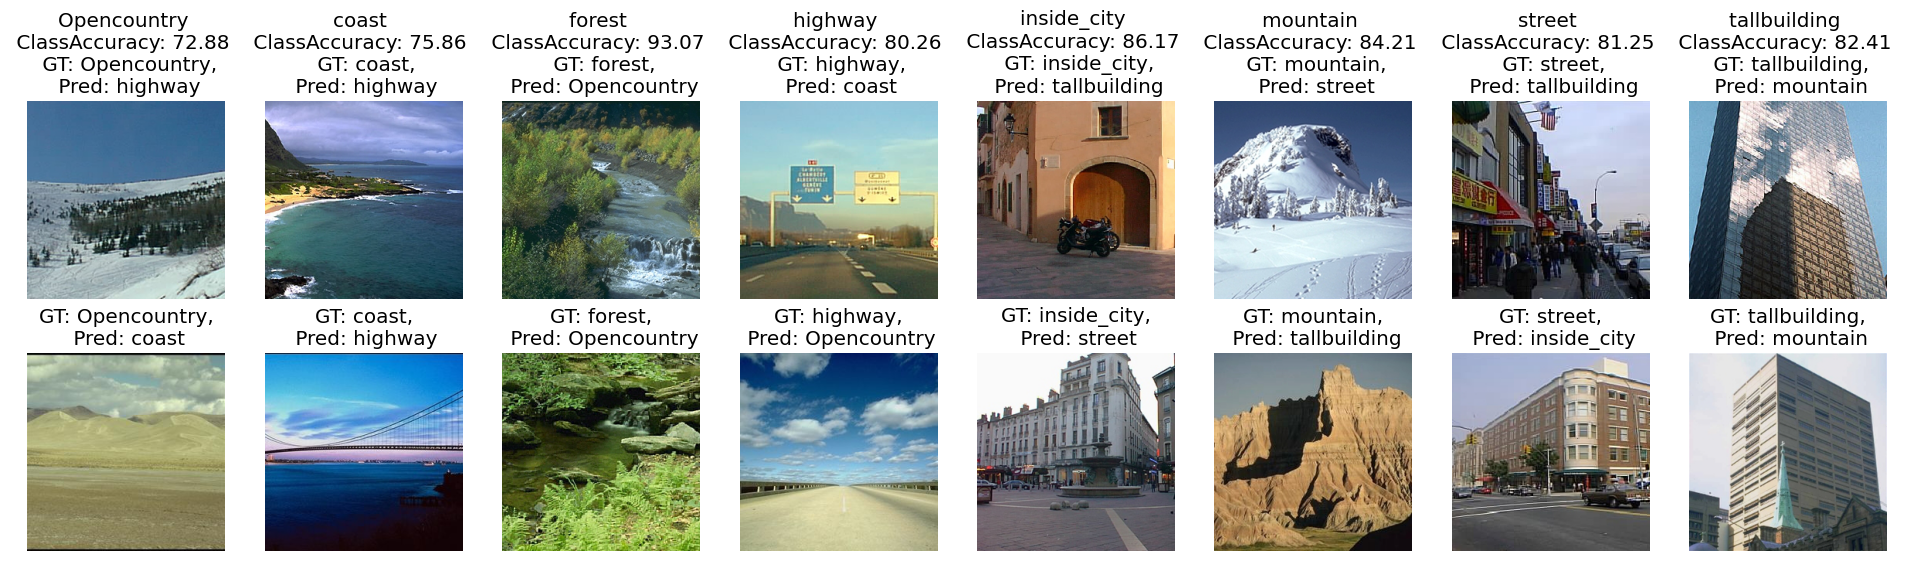

In [74]:
visualize_wrong_predictions(test_images_filenames, test_labels, test_prediction)

Number of samples: 807
Number of correctly classified samples: 660


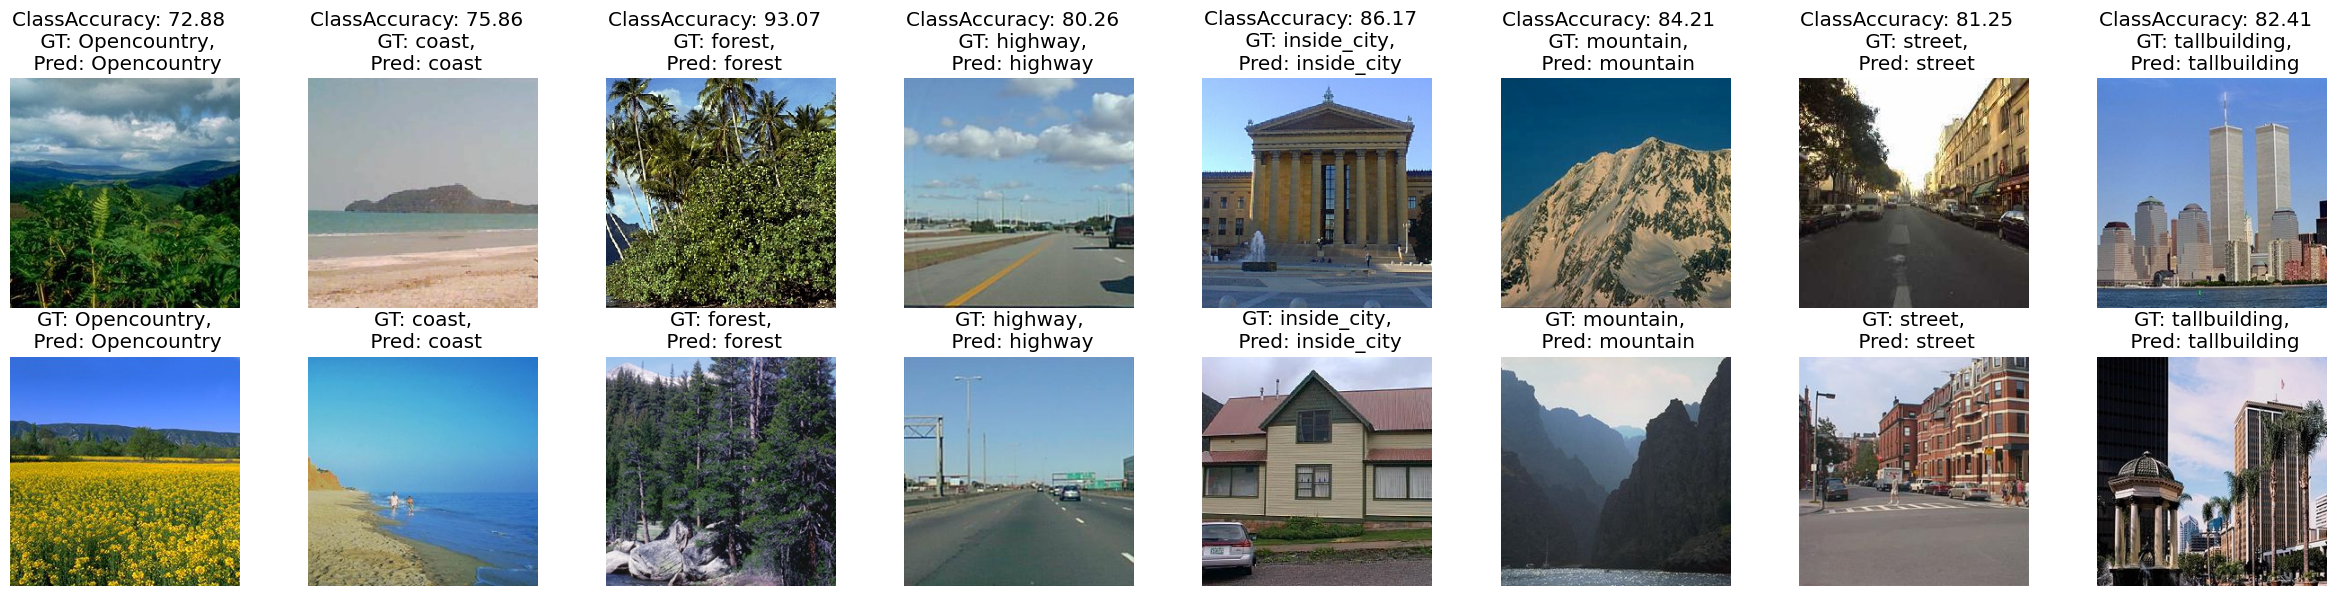

In [75]:
visualize_correct_predictions(test_images_filenames, test_labels, test_prediction)

#### **Conclusions of week 2**
The classes which are difficult to predict for the model are also difficult to predict for humans. As we can see in most of the wrongly classified examples, they are wrong because they look very similar to the other classes visually, so it is not a surprise that the model has a difficulty in predicting them. The used dataset is tricky as well, as some classes contain other classes as elements. For example, an image of the class inside_city, might include the view of a street or tall buildings, which are classes themselves.